#Load data

In [1]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import math

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# Train/test split
df_full = df_raw.sample(frac = 0.8, random_state = 40)
df_test = df_raw.drop(df_full.index)

# Changing inc_angle from object to float64
df_full.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df_full['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df_full[df_full.inc_angle.isna()] # 133 NaN

# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['delta_b'+str(label)] = [(np.max(np.array(matx))-np.min(np.array(matx))) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]
  return data
  
df_full = add_features(df_full,1)
df_full = add_features(df_full,2)

df_full['delta_max'] = df_full[['delta_b1','delta_b2']].apply(np.max,axis=1)

# Creating the two weighted bands
df_full["band_2ab"] = (2*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(1*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))
df_full["band_a2b"] = (1*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(2*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))

# Creating the final dataframe
df = pd.DataFrame()
df['band_1'] = df_full["band_2ab"]
df['band_2'] = df_full["band_a2b"]
df['is_iceberg'] = df_full['is_iceberg']
df['inc_angle'] = df_full['inc_angle']

Mounted at /content/drive


# Adding app

In [2]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

import cv2 as cv
from google.colab.patches import cv2_imshow



# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve

from scipy.optimize import fmin, minimize_scalar

def show_bands(row):
  print(f'Index : {row.name}')
  f, (img1, img2) = plt.subplots(1, 2, figsize = (10,10))
  img1.imshow(np.array(row.band_1).reshape(75,75))
  img1.set_title("band_1")
  img2.imshow(np.array(row.band_2).reshape(75,75))
  img2.set_title("band_2")
  img1.set_yticks([])
  img1.set_xticks([])
  img2.set_yticks([])
  img2.set_xticks([])
  plt.show()

class EvaluateAndReport:
  def __init__(self, df, X_train, X_test, y_train, y_test, scoring = 'f1', grid_cv = 5, cv_cv = 10, best_scores_t = {}):
    self.df = df
    self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test
    self.scoring = scoring
    self.grid_cv = grid_cv
    self.cv_cv = cv_cv
    #self.threshold = threshold
    self.best_scores_t = best_scores_t


  def grid_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      print('--- Grid Search Report ---')
      grid_search = GridSearchCV(classifier, param_grid, cv = self.grid_cv, scoring = self.scoring, return_train_score = True)
      grid_search.fit(self.X_train, self.y_train)

      print(f'Best parameters for {classifier} :\n {grid_search.best_params_} with {self.scoring} score {round(grid_search.best_score_,3)}')

      self.last_best = grid_search.best_estimator_
    else:
      print("cross_report should be used when there is no param_grid")


  def cross_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Cross Validation Report ---')
    scorings = ('accuracy', 'f1', 'precision', 'recall')
    scores = cross_validate(classifier, self.X_train, self.y_train, cv = self.cv_cv, scoring = scorings)
    self.best_scores_t = {scoring : round(np.mean(scores["test_"+scoring]),3) for scoring in scorings}
    [print(f'Mean {scoring} score {round(np.mean(scores["test_"+scoring]),3)} with std {round(np.std(scores["test_"+scoring]),3)}') for scoring in scorings]


  def test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Test Sample Report ---')
    classifier.fit(self.X_train, self.y_train)
    self.last_y_pred = classifier.predict(self.X_test)

    print(f'Scores for the test sample :')
    print(f' accuracy : {round(accuracy_score(self.y_test, self.last_y_pred),3)}')
    print(f' f1 : {round(f1_score(self.y_test, self.last_y_pred),3)}')
    print(f' precision : {round(precision_score(self.y_test, self.last_y_pred),3)}')
    print(f' recall : {round(recall_score(self.y_test, self.last_y_pred),3)}')

    print('Confusion matrix for the test sample :')
    cm = confusion_matrix(self.y_test, self.last_y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Boat','Iceberg']).plot(cmap="Blues", values_format='')


  def grid_cross_test_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      self.grid_report(classifier, param_grid)
      self.cross_report(self.last_best)
      self.test_report(self.last_best)
    else:
      print('cross_test_report should be used when there is no param_grid')

  def cross_test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    self.cross_report(classifier)
    self.test_report(classifier)

  def cross_proba_report(self, classifier = None, threshold = 0.5):
    if classifier is None:
      classifier = self.last_best
    print(f'--- Cross Validation with {threshold} Threshold Report ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, threshold))

  def calc_proba_scores(self, y_train_scores, threshold):
    y_pred = (y_train_scores >= threshold)
    return (accuracy_score(self.y_train, y_pred), f1_score(self.y_train, y_pred, zero_division=0), precision_score(self.y_train, y_pred, zero_division=0), recall_score(self.y_train, y_pred, zero_division=0))

  def print_proba_scores(self, scores):
    print(f' accuracy : {round(scores[0],3)}')
    print(f' f1 : {round(scores[1],3)}')
    print(f' precision : {round(scores[2],3)}')
    print(f' recall : {round(scores[3],3)}')

  def full_cross_proba_report(self, classifier = None, res = 50):
    if classifier is None:
      classifier = self.last_best
    print(f'--- Threshold Report ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    probas = np.linspace(0.0,1.0,res)
    full_scores = np.array([self.calc_proba_scores(y_train_scores, threshold) for threshold in probas])

    plt.figure(figsize=(8,6))
    plt.plot(probas, full_scores[:,0], "b-", label="Accuracy", linewidth=2)
    plt.plot(probas, full_scores[:,1], "g-", label="F1", linewidth=2)
    plt.plot(probas, full_scores[:,2], "r-", label="Precision", linewidth=2)
    plt.plot(probas, full_scores[:,3], "c-", label="Recall", linewidth=2)
    plt.xlabel("Probablility threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0.4, 1])
    plt.xlim([0, 1])
    plt.grid(b=True, linestyle='-')

    #Searching for optimals
    acc_opt = minimize_scalar(lambda x : -self.calc_proba_scores(y_train_scores, x)[0], bracket=(0.0,1.0))
    if acc_opt.x < 0: acc_opt.x = 0.0
    elif acc_opt.x > 1 : acc_opt.x = 1.0
    print(f'Optimal threshold for accuracy is {round(acc_opt.x,2)} with:')
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, acc_opt.x))

    acc_opt = minimize_scalar(lambda x : -self.calc_proba_scores(y_train_scores, x)[1], bracket=(0.0,1.0))
    if acc_opt.x < 0: acc_opt.x = 0.0
    elif acc_opt.x > 1 : acc_opt.x = 1.0
    print(f'Optimal threshold for f1 is {round(acc_opt.x,2)} with:')
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, acc_opt.x))

  def plot_precision_recall(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Precision Recall Curves ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    precisions, recalls, probas = precision_recall_curve(self.y_train, y_train_scores)

    plt.figure(0)
    plt.plot(probas, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(probas, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Probablility threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0, 1])

    plt.figure(1)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

  def plot_mistakes(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for wrongly predicted individuals
    #By default, false positives and false negatives are shown. If one is chosen in 'nature', the other ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boat_as_iceberg':
      print('--- Icebergs predicted as boats ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'iceberg_as_boat':
      print('--- Boats predicted as Icebergs ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)

  def plot_predicted(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for correclty predicted individuals
    #By default, correctly predicted icebergs and boats are shown. If one is chosen in 'nature', the others ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boats':
      print('--- Icebergs predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'icebergs':
      print('--- Boats predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)


# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['variance_b'+str(label)] = [np.var(np.array(matx)) for matx in data['band_'+str(label)]]



  #data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]

  return data


# Adding sobel features to the initial dataset

def add_sobel_features(datasobel, label, data) :
  #Find the contour pixels by taking out the max 75 elements
  
  datasobel['contourpixel_b'+str(label)] = [np.array(matx)[np.argpartition(np.array(matx), -75)[-75:]] for matx in datasobel['band_'+str(label)]]

  data['max_of_contour_b'+str(label)] = [np.max(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['min_of_contour_b'+str(label)] = [np.min(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['median_of_contour_b'+str(label)] = [np.median(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['mean_of_contour_b'+str(label)] = [np.mean(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmax_of_contour_b'+str(label)] = [np.argmax(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmin_of_contour_b'+str(label)] = [np.argmin(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['variance_of_contour_b'+str(label)] = [np.var(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]

  return data

def contour(matx):

  image = rs.denoise_tv_chambolle(rs.denoise_bilateral(np.array(matx), sigma_spatial = 1), weight = 0.1)
  image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
  
  image_8bit = np.array(np.uint8(image * 255))

  threshold_level = 155 # Set as we need...
  ret, binarized = cv.threshold(image_8bit, threshold_level, 255, cv.THRESH_BINARY)
  #binarized= cv.adaptiveThreshold(image_8bit,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

  contours, _ = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cv.drawContours(image, contours,-1,(0,255,0), 1)
  plt.imshow(image)
  cnt = contours[0]
  if cnt.size<10:
    cnt=contours[len(contours)-1]


  #Surace area of the contour
  area = cv.contourArea(cnt)

  #Perimeter of the contour
  perimeter = cv.arcLength(cnt,True)

  #A/P ratio
  AP_Ratio=area/perimeter

  #Ellipse
  if cnt.size>=10:
    ellipse = (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
    A = np.pi * MA * ma/4
    ellipse_ratio=area/A
  else: 
    ellipse_ratio = "not_available"

  #Rectangle
  #Get Rec
  rect = cv.minAreaRect(cnt)
  box = cv.boxPoints(rect)
  box = np.int0(box)
  
  #Calculate Rec area
  a=math.sqrt((box[0][0]-box[1][0])**2+(box[0][1]-box[1][1])**2)
  b=math.sqrt((box[1][0]-box[2][0])**2+(box[1][1]-box[2][1])**2)
  Rec = a*b
  
  #Calculate Rec Ratio
  rec_ratio=area/Rec
  rec_ratio

  return area, perimeter, AP_Ratio, ellipse_ratio, rec_ratio


def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

def MatrixtoArray(data, label) :
  data['band_'+str(label)] = [np.array(matx).ravel() for matx in data['band_'+str(label)]]

# Plotting the new feature in a histogram
def plot_features(data, name):
  plt.hist(data.loc[data.is_iceberg==1,name], bins=50, color='navy',alpha=0.5,label='Iceberg')
  plt.hist(data.loc[data.is_iceberg==0,name], bins=50,color='firebrick',alpha=0.5, label='Bateau')
  plt.legend()
  plt.xlabel(name)
  #plt.ylabel('Frequency')
  plt.show()

# Loading the dataset and importing libraries


In [3]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from numpy import fft
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Data treatment

In [4]:
#df.head()

In [5]:
#plt.imshow(df.iat[1,1])

## Image pretreatment example

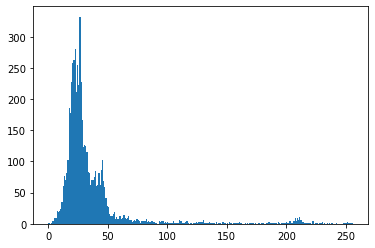

In [6]:
from functools import partial
import pywt
from skimage import feature
from skimage.filters import sobel
import skimage as sk
import skimage.filters as fl
import skimage.restoration as rs
  
image = rs.denoise_tv_chambolle(rs.denoise_bilateral(np.array(df.iat[888,1]), sigma_spatial = 1), weight = 0.1)
image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
image_8bit = np.uint8(image * 255)
            
plt.hist(image_8bit.ravel(),bins = 256, range = [0, 256])
plt.show()

(170.5,
 75.35533833503723,
 2.2626134228465706,
 0.5963212652990765,
 [array([[[41, 23]],
  
         [[40, 24]],
  
         [[40, 25]],
  
         [[39, 26]],
  
         [[39, 27]],
  
         [[36, 30]],
  
         [[34, 30]],
  
         [[33, 31]],
  
         [[32, 31]],
  
         [[31, 32]],
  
         [[29, 32]],
  
         [[28, 33]],
  
         [[27, 33]],
  
         [[26, 34]],
  
         [[23, 34]],
  
         [[22, 35]],
  
         [[21, 35]],
  
         [[19, 37]],
  
         [[18, 37]],
  
         [[18, 39]],
  
         [[20, 41]],
  
         [[21, 40]],
  
         [[24, 40]],
  
         [[25, 39]],
  
         [[27, 39]],
  
         [[28, 38]],
  
         [[30, 38]],
  
         [[31, 37]],
  
         [[36, 37]],
  
         [[37, 38]],
  
         [[39, 38]],
  
         [[41, 36]],
  
         [[42, 36]],
  
         [[43, 35]],
  
         [[43, 31]],
  
         [[42, 30]],
  
         [[42, 25]],
  
         [[43, 24]],
  
         [[42, 23]

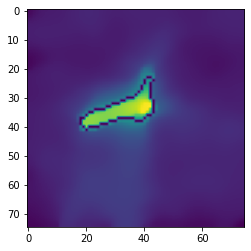

In [7]:
  threshold_level = 127 #np.amax(image_8bit)/2 # Set as we need...
  
  ret, binarized = cv.threshold(image_8bit, threshold_level, 255, cv.THRESH_BINARY)
  #binarized= cv.adaptiveThreshold(image_8bit,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

  contours, _ = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cnt = contours[0]
  cv.drawContours(image, contours, -1, (0,255,0), 1)
  plt.imshow(image)
  cnt
  #threshold_level


  #Surace area of the contour
  area = cv.contourArea(cnt)
  
  #Perimeter of the contour
  perimeter = cv.arcLength(cnt,True)

  #A/P ratio
  AP_Ratio=area/perimeter

  #Ellipse
  ellipse = (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
  A = np.pi * MA * ma/4
  ellipse_ratio=area/A

  area, perimeter, AP_Ratio, ellipse_ratio, contours

##Add OpenCV contours

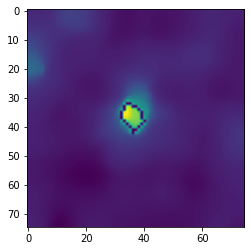

In [8]:
df=apply_and_concat(df, 'band_1', contour, ['area1', 'perimeter1', 'AP_Ratio1', 'ellipse_ratio1','rec_ratio1'])
df=apply_and_concat(df, 'band_2', contour, ['area2', 'perimeter2', 'AP_Ratio2', 'ellipse_ratio2','rec_ratio2'])

##Denoise images

In [9]:
#Denoise all images and draw the contour
def denoiseimg(x):
  y = np.array(x).reshape(75,75)
  #y = (y - y.min())/(y.max()-y.min())
  y = rs.denoise_tv_chambolle(rs.denoise_bilateral(y.reshape(75,75), sigma_spatial = 1), weight = 0.1)
  y = y.ravel()
  return y

df["band_1"]=df["band_1"].apply(denoiseimg)
df["band_2"]=df["band_2"].apply(denoiseimg)

df.head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2
486,"[0.3355775335842331, 0.33493948584738453, 0.33...","[0.31956969827674825, 0.31928660892872895, 0.3...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556
760,"[0.2513751371634836, 0.25150778696110543, 0.25...","[0.25079425332244637, 0.2508456971250878, 0.25...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622
1502,"[0.3723931654571044, 0.37171637732336404, 0.37...","[0.3933240483745459, 0.3921672755482756, 0.390...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500
682,"[0.22155687429877088, 0.2218296214479607, 0.22...","[0.23321872433837001, 0.23340868623025782, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000
1324,"[0.4277686237247893, 0.42832100239594645, 0.42...","[0.42358939818204333, 0.4241049723265055, 0.42...",1,43.9204,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661


## Add general features

In [10]:
# Adding all possible features 
df = add_features(df,1)
df = add_features(df,2)
df.head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2
486,"[0.3355775335842331, 0.33493948584738453, 0.33...","[0.31956969827674825, 0.31928660892872895, 0.3...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.673037,0.279277,0.321376,0.329599,3030,5561,0.001465,0.700185,0.269896,0.298510,0.306583,2955,5562,0.001615
760,"[0.2513751371634836, 0.25150778696110543, 0.25...","[0.25079425332244637, 0.2508456971250878, 0.25...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.718197,0.241889,0.271650,0.279537,2739,4875,0.001983,0.621322,0.232657,0.252365,0.259993,2739,5025,0.001306
1502,"[0.3723931654571044, 0.37171637732336404, 0.37...","[0.3933240483745459, 0.3921672755482756, 0.390...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.673343,0.338697,0.395267,0.403209,2358,3451,0.001360,0.563227,0.332550,0.401291,0.404027,2358,4197,0.000723
682,"[0.22155687429877088, 0.2218296214479607, 0.22...","[0.23321872433837001, 0.23340868623025782, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.610324,0.212600,0.235882,0.240507,2737,5566,0.000888,0.473743,0.223431,0.239144,0.242225,2662,5568,0.000381
1324,"[0.4277686237247893, 0.42832100239594645, 0.42...","[0.42358939818204333, 0.4241049723265055, 0.42...",1,43.9204,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661,0.729472,0.342745,0.403030,0.405857,2587,5250,0.000748,0.679161,0.300586,0.400766,0.402461,2587,5614,0.000596


##Add Sobel Contour Features

In [11]:
# Adding sobel contour features 
df_sobel = pd.DataFrame(columns=['band_1','band_2'])

def sobelimg(x):
  y = np.array(x).reshape(75,75)
  y = sobel(y)
  y = y.ravel()
  return y

df_sobel["band_1"]=df["band_1"].apply(sobelimg)
df_sobel["band_2"]=df["band_2"].apply(sobelimg)


df = add_sobel_features(df_sobel,1,df)
df = add_sobel_features(df_sobel,2,df)
df.head()



,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,argmin_of_contour_b2,variance_of_contour_b2
486,"[0.3355775335842331, 0.33493948584738453, 0.33...","[0.31956969827674825, 0.31928660892872895, 0.3...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.673037,0.279277,0.321376,0.329599,3030,5561,0.001465,0.700185,0.269896,0.298510,0.306583,2955,5562,0.001615,0.195340,0.093825,0.125055,0.132238,34,0,0.000684,0.228455,0.098129,0.135163,0.144050,52,0,0.001216
760,"[0.2513751371634836, 0.25150778696110543, 0.25...","[0.25079425332244637, 0.2508456971250878, 0.25...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.718197,0.241889,0.271650,0.279537,2739,4875,0.001983,0.621322,0.232657,0.252365,0.259993,2739,5025,0.001306,0.205473,0.079472,0.110376,0.118565,67,0,0.001053,0.191968,0.068797,0.093696,0.106765,30,0,0.001246
1502,"[0.3723931654571044, 0.37171637732336404, 0.37...","[0.3933240483745459, 0.3921672755482756, 0.390...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.673343,0.338697,0.395267,0.403209,2358,3451,0.001360,0.563227,0.332550,0.401291,0.404027,2358,4197,0.000723,0.130953,0.038285,0.066682,0.069859,63,0,0.000587,0.054072,0.027692,0.035979,0.037507,44,0,0.000044
682,"[0.22155687429877088, 0.2218296214479607, 0.22...","[0.23321872433837001, 0.23340868623025782, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.610324,0.212600,0.235882,0.240507,2737,5566,0.000888,0.473743,0.223431,0.239144,0.242225,2662,5568,0.000381,0.199760,0.064064,0.097507,0.109619,59,0,0.001530,0.115416,0.033901,0.062868,0.064211,62,0,0.000513
1324,"[0.4277686237247893, 0.42832100239594645, 0.42...","[0.42358939818204333, 0.4241049723265055, 0.42...",1,43.9204,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661,0.729472,0.342745,0.403030,0.405857,2587,5250,0.000748,0.679161,0.300586,0.400766,0.402461,2587,5614,0.000596,0.199295,0.055931,0.089024,0.103756,71,0,0.002067,0.167710,0.047675,0.073733,0.085875,57,0,0.001324


##Split all the pixels into a table called X

In [12]:
naive_base_pretreated = X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

In [13]:
X

,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,band_1_8,band_1_9,band_1_10,band_1_11,band_1_12,band_1_13,band_1_14,band_1_15,band_1_16,band_1_17,band_1_18,band_1_19,band_1_20,band_1_21,band_1_22,band_1_23,band_1_24,band_1_25,band_1_26,band_1_27,band_1_28,band_1_29,band_1_30,band_1_31,band_1_32,band_1_33,band_1_34,band_1_35,band_1_36,band_1_37,band_1_38,band_1_39,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
486,0.335578,0.334939,0.333478,0.330896,0.328066,0.326692,0.325733,0.325051,0.324640,0.324437,0.324410,0.324416,0.324180,0.323507,0.322195,0.319578,0.315186,0.310574,0.307867,0.306596,0.306158,0.306512,0.307535,0.308645,0.309592,0.310236,0.310841,0.311839,0.313020,0.314225,0.314777,0.314767,0.314507,0.314356,0.314583,0.315266,0.315998,0.316851,0.317953,0.319376,...,0.277594,0.275361,0.273914,0.272672,0.272270,0.272346,0.272795,0.273271,0.285061,0.297593,0.304712,0.309312,0.314103,0.318610,0.322357,0.328036,0.333159,0.337030,0.340405,0.342629,0.343474,0.343355,0.342245,0.339654,0.334079,0.328502,0.321347,0.311842,0.304773,0.302921,0.301306,0.300452,0.300241,0.300625,0.301784,0.303218,0.304376,0.305305,0.305939,0.306295
760,0.251375,0.251508,0.251739,0.252027,0.252383,0.252868,0.253309,0.253715,0.254682,0.255358,0.255727,0.256116,0.256329,0.256778,0.257255,0.257936,0.258881,0.260131,0.261427,0.262699,0.263751,0.264563,0.265120,0.265506,0.265766,0.265943,0.266163,0.266506,0.267073,0.267977,0.269222,0.270547,0.271599,0.272048,0.272001,0.271539,0.270444,0.268542,0.266490,0.264558,...,0.251831,0.251831,0.251858,0.251919,0.252005,0.252128,0.252195,0.252233,0.252165,0.252005,0.251656,0.251065,0.250180,0.249162,0.248041,0.246476,0.245619,0.244926,0.244322,0.244022,0.243974,0.244250,0.244797,0.245676,0.246487,0.247279,0.248176,0.248949,0.249578,0.250042,0.250302,0.250399,0.250352,0.250216,0.250039,0.249808,0.249564,0.249331,0.249152,0.249076
1502,0.372393,0.371716,0.370733,0.370239,0.370642,0.372437,0.376888,0.382421,0.387967,0.392491,0.395027,0.396069,0.396249,0.395574,0.393896,0.391204,0.387629,0.384417,0.382103,0.380628,0.380431,0.381791,0.384277,0.386643,0.387945,0.388314,0.387829,0.386399,0.384383,0.381970,0.379526,0.377825,0.376841,0.375967,0.375179,0.374500,0.373660,0.373012,0.372523,0.372338,...,0.389890,0.391266,0.392397,0.394017,0.395708,0.398284,0.400580,0.402950,0.406472,0.407729,0.408295,0.408489,0.408351,0.408471,0.408958,0.410483,0.412870,0.414363,0.415518,0.416173,0.416373,0.416125,0.415717,0.415040,0.414227,0.413139,0.412093,0.410297,0.408118,0.405589,0.402837,0.400302,0.398584,0.397270,0.396212,0.395558,0.395454,0.395679,0.396109,0.396534
682,0.221557,0.221830,0.222342,0.223119,0.224194,0.225478,0.227166,0.228490,0.229271,0.229619,0.229677,0.229474,0.229069,0.228520,0.227936,0.227529,0.227277,0.227126,0.227039,0.227027,0.227106,0.227288,0.227615,0.228074,0.228611,0.229196,0.230005,0.231208,0.233085,0.235551,0.238323,0.242318,0.247112,0.251401,0.254840,0.257455,0.258910,0.259256,0.258901,0.257765,...,0.234789,0.235723,0.236750,0.237875,0.239024,0.240500,0.241943,0.242761,0.243402,0.243654,0.243478,0.242820,0.241647,0.239771,0.237902,0.236654,0.235668,0.234980,0.234741,0.234841,0.235253,0.235924,0.236597,0.237291,0.237999,0.238555,0.239242,0.239816,0.240303,0.240718,0.240965,0.241084,0.241112,0.241036,0.240878,0.240697,0.240477,0.240233,0.240062,0.239960
1324,0.427769,0.428321,0.428980,0.429478,0.429075,0.427325,0.423692,0.419730,0.416538,0.413590,0.411294,0.409235,0.407568,0.405862,0.404106,0.402444,0.400548,0.398716,0.396373,0.388171,0.382343,0.379334,0.377046,

##Join the split pixels with images and features

In [14]:
# splitting the bands into single elements
df = df.join(naive_base_pretreated)

In [15]:
df.head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
486,"[0.3355775335842331, 0.33493948584738453, 0.33...","[0.31956969827674825, 0.31928660892872895, 0.3...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.673037,0.279277,0.321376,0.329599,3030,5561,0.001465,0.700185,0.269896,0.298510,0.306583,2955,5562,0.001615,0.195340,0.093825,0.125055,0.132238,34,0,0.000684,0.228455,0.098129,0.135163,0.144050,52,...,0.277594,0.275361,0.273914,0.272672,0.272270,0.272346,0.272795,0.273271,0.285061,0.297593,0.304712,0.309312,0.314103,0.318610,0.322357,0.328036,0.333159,0.337030,0.340405,0.342629,0.343474,0.343355,0.342245,0.339654,0.334079,0.328502,0.321347,0.311842,0.304773,0.302921,0.301306,0.300452,0.300241,0.300625,0.301784,0.303218,0.304376,0.305305,0.305939,0.306295
760,"[0.2513751371634836, 0.25150778696110543, 0.25...","[0.25079425332244637, 0.2508456971250878, 0.25...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.718197,0.241889,0.271650,0.279537,2739,4875,0.001983,0.621322,0.232657,0.252365,0.259993,2739,5025,0.001306,0.205473,0.079472,0.110376,0.118565,67,0,0.001053,0.191968,0.068797,0.093696,0.106765,30,...,0.251831,0.251831,0.251858,0.251919,0.252005,0.252128,0.252195,0.252233,0.252165,0.252005,0.251656,0.251065,0.250180,0.249162,0.248041,0.246476,0.245619,0.244926,0.244322,0.244022,0.243974,0.244250,0.244797,0.245676,0.246487,0.247279,0.248176,0.248949,0.249578,0.250042,0.250302,0.250399,0.250352,0.250216,0.250039,0.249808,0.249564,0.249331,0.249152,0.249076
1502,"[0.3723931654571044, 0.37171637732336404, 0.37...","[0.3933240483745459, 0.3921672755482756, 0.390...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.673343,0.338697,0.395267,0.403209,2358,3451,0.001360,0.563227,0.332550,0.401291,0.404027,2358,4197,0.000723,0.130953,0.038285,0.066682,0.069859,63,0,0.000587,0.054072,0.027692,0.035979,0.037507,44,...,0.389890,0.391266,0.392397,0.394017,0.395708,0.398284,0.400580,0.402950,0.406472,0.407729,0.408295,0.408489,0.408351,0.408471,0.408958,0.410483,0.412870,0.414363,0.415518,0.416173,0.416373,0.416125,0.415717,0.415040,0.414227,0.413139,0.412093,0.410297,0.408118,0.405589,0.402837,0.400302,0.398584,0.397270,0.396212,0.395558,0.395454,0.395679,0.396109,0.396534
682,"[0.22155687429877088, 0.2218296214479607, 0.22...","[0.23321872433837001, 0.23340868623025782, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.610324,0.212600,0.235882,0.240507,2737,5566,0.000888,0.473743,0.223431,0.239144,0.242225,2662,5568,0.000381,0.199760,0.064064,0.097507,0.109619,59,0,0.001530,0.115416,0.033901,0.062868,0.064211,62,...,0.234789,0.235723,0.236750,0.237875,0.239024,0.240500,0.241943,0.242761,0.243402,0.243654,0.243478,0.242820,0.241647,0.239771,0.237902,0.236654,0.235668,0.234980,0.234741,0.234841,0.235253,0.235924,0.236597,0.237291,0.237999,0.238555,0.239242,0.239816,0.240303,0.240718,0.240965,0.241084,0.241112,0.241036,

In [16]:
df["band_1"][824]

array([0.24879781, 0.24893795, 0.24917352, ..., 0.21167108, 0.20090981,
       0.19964264])

## Histograms of features

In [17]:
#There are 13 images where there are fewer than 4 points on the contour therefore not possible to draw an ellipse

df[(df["ellipse_ratio1"]=='not_available') | (df["ellipse_ratio2"]=='not_available')]

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
1270,"[0.5408688500189496, 0.5399010595272254, 0.538...","[0.5172515009477657, 0.5161052086172648, 0.514...",1,37.2802,6.0,10.828427,0.554097,not_available,0.750000,11.0,14.828427,0.741818,0.72866,0.733333,0.665399,0.413486,0.451293,0.452482,2882,2334,0.000571,0.624500,0.396202,0.447009,0.447208,2882,5590,0.000397,0.146070,0.021232,0.032914,0.048332,60,0,0.001162,0.111160,0.017410,0.026491,0.040072,68,...,0.410649,0.405141,0.400516,0.398229,0.396794,0.396202,0.396252,0.396754,0.397768,0.399903,0.402913,0.407429,0.412370,0.417212,0.421868,0.426572,0.431108,0.434217,0.436913,0.439418,0.441634,0.444443,0.446868,0.448968,0.451609,0.454243,0.456270,0.457598,0.458397,0.458849,0.458910,0.458729,0.458274,0.457495,0.456259,0.454985,0.453918,0.452908,0.451859,0.451427
1445,"[0.44317781092674075, 0.44403456603967734, 0.4...","[0.5015274935135359, 0.501732345629219, 0.5020...",1,34.4709,80.5,39.556349,2.035072,0.786243,0.670833,1.0,4.828427,0.207107,not_available,0.316228,0.767597,0.409192,0.478251,0.483066,2811,858,0.001696,0.777040,0.238734,0.528456,0.532384,2810,12,0.001363,0.114323,0.055870,0.076580,0.078810,52,0,0.000251,0.169960,0.051920,0.071424,0.077261,33,...,0.556297,0.562867,0.567544,0.569635,0.570418,0.570335,0.569150,0.567277,0.564951,0.561754,0.557682,0.553670,0.549695,0.546586,0.544066,0.542100,0.540342,0.538662,0.537158,0.535802,0.534701,0.533644,0.532196,0.530172,0.528805,0.527684,0.526902,0.526672,0.526868,0.527478,0.528407,0.529181,0.529751,0.529971,0.529861,0.529429,0.528639,0.527527,0.526322,0.525438
1183,"[0.4347151018049139, 0.4346522193978121, 0.434...","[0.4261978111744026, 0.42611542482674797, 0.42...",1,34.8498,4.0,8.000000,0.500000,not_available,1.000000,15.0,17.656854,0.849528,0.516406,0.714286,0.653605,0.343127,0.406090,0.406738,2888,5466,0.000275,0.588897,0.262989,0.427952,0.428668,2888,5250,0.000192,0.158118,0.013728,0.018239,0.048057,66,0,0.002339,0.107017,0.013755,0.018894,0.036494,65,...,0.439536,0.434328,0.430991,0.428622,0.426309,0.424429,0.422943,0.421332,0.419555,0.418205,0.417209,0.416207,0.415696,0.415705,0.416357,0.417761,0.420486,0.425055,0.431738,0.434983,0.437511,0.438746,0.438814,0.437566,0.435038,0.430281,0.424573,0.417810,0.412723,0.409249,0.407127,0.405611,0.404904,0.404377,0.403618,0.402480,0.400797,0.398018,0.396981,0.396403
9,"[0.30339483351124463, 0.3042217763698067, 0.30...","[0.2925897888886115, 0.29326229154461825, 0.29...",0,43.3007,7.0,10.828427,0.646447,0.652643,0.777778,4.0,8.000000,0.500000,not_available,1.000000,0.692242,0.302992,0.339989,0.340131,2811,3231,0.000320,0.613187,0.292590,0.325226,0.325476,2811,0,0.000217,0.237484,0.010736,0.046467,0.078522,47,0,0.005481,0.187154,0.008768,0.023412,0.058617,72,...,0.328144,0.328442,0.329617,0.331524,0.333977,0.336492,0.338555,0.339578,0.340043,0.340077,0.339519,0.338297,0.337172,0.336260,0.335383,0.334459,0.333735,0.332941,0.331779,0.330526,0.328858,0.326670,0.324109,0.321425,0.320137,0.319514,0.319033,0.318763,0.318553,0.318216,0.317424,0.316108,0.314112,0.311

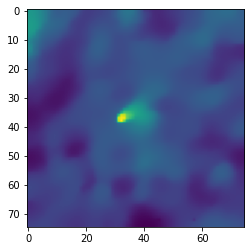

In [18]:
example=np.array(df.loc[[1270],'band_2'])
plt.imshow(example[0].reshape(75,75))

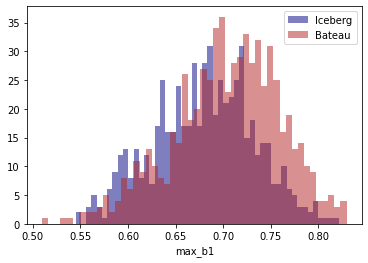

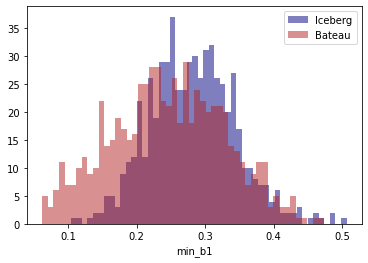

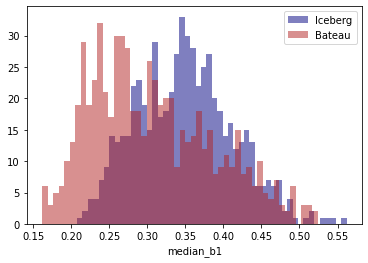

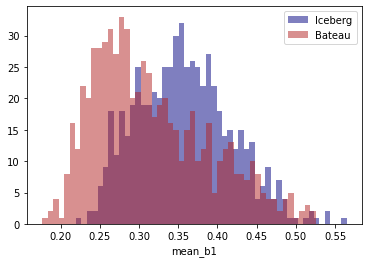

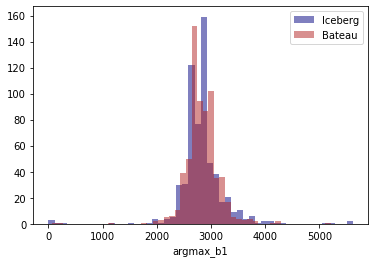

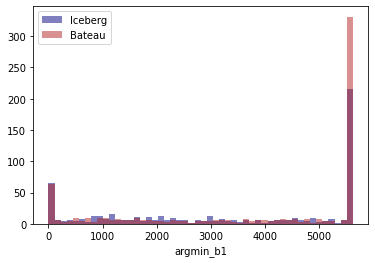

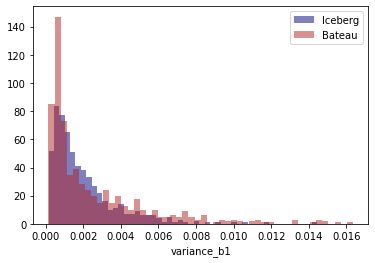

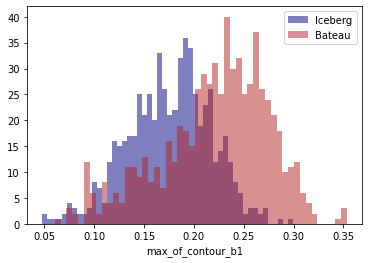

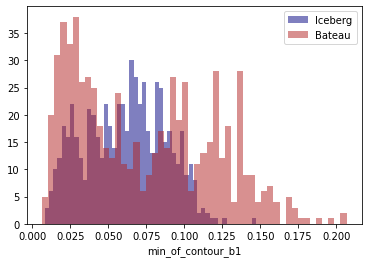

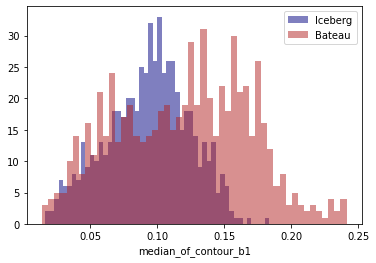

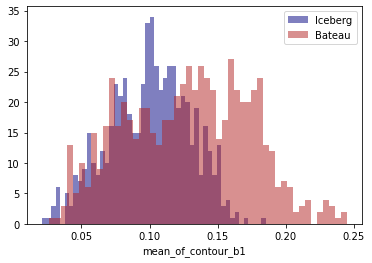

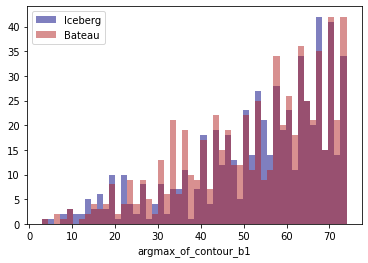

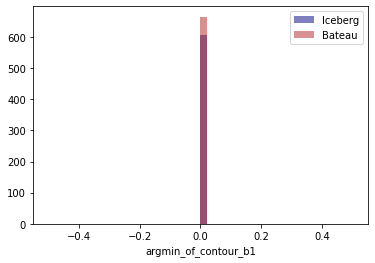

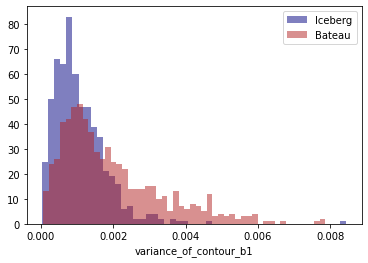

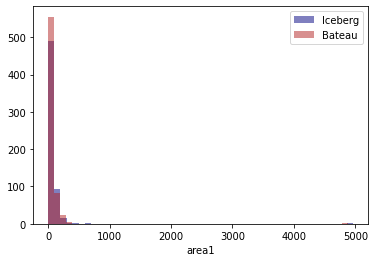

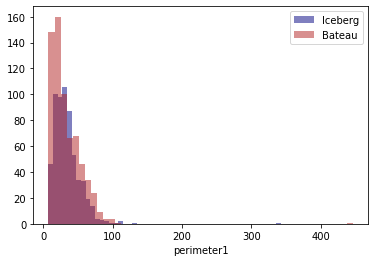

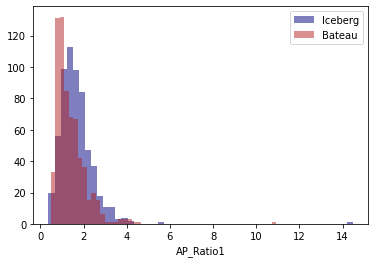

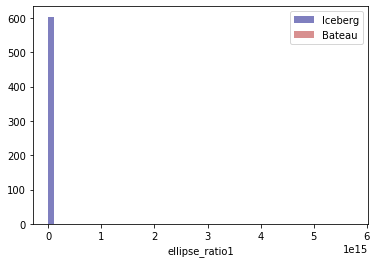

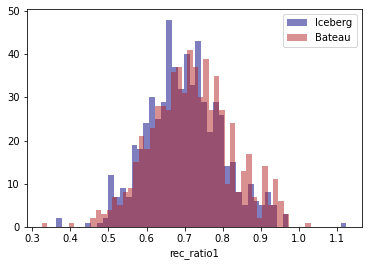

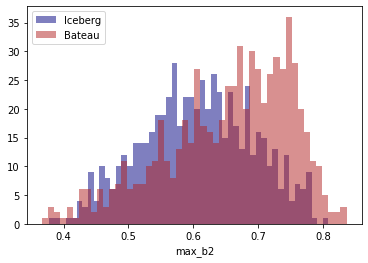

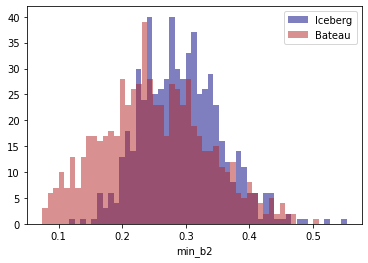

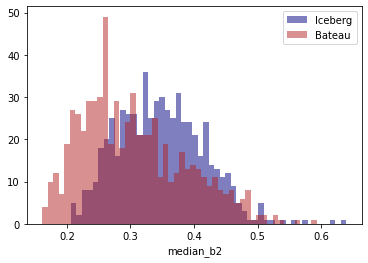

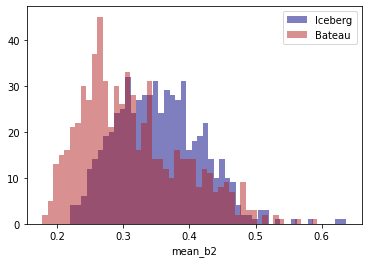

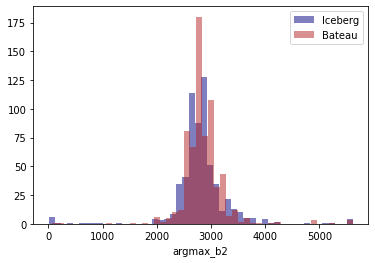

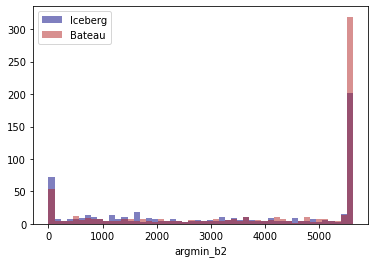

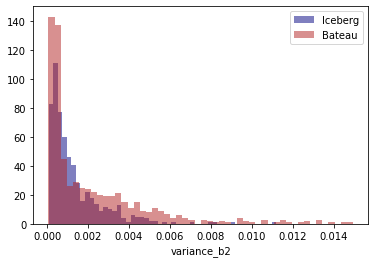

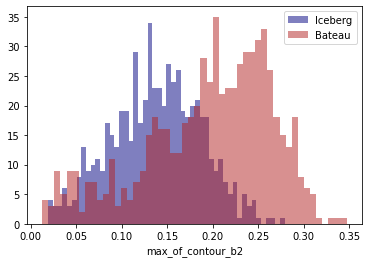

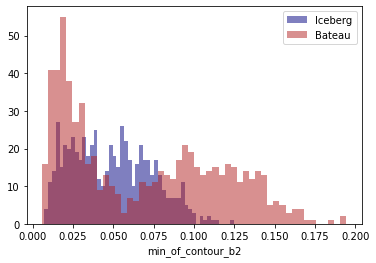

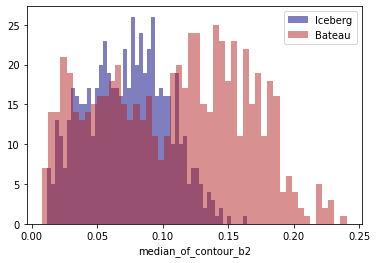

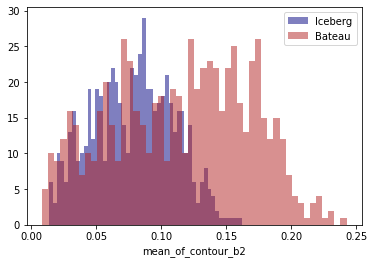

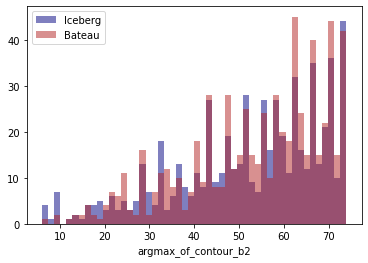

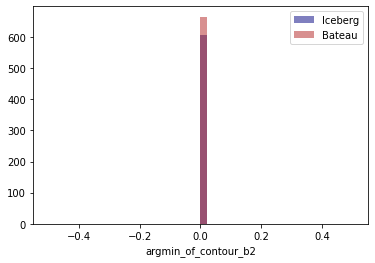

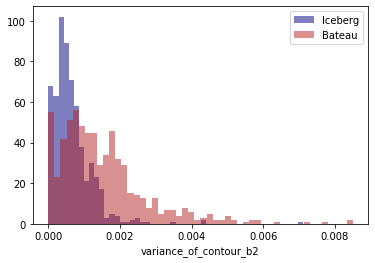

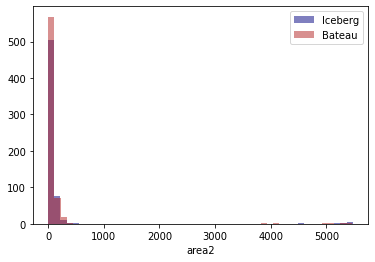

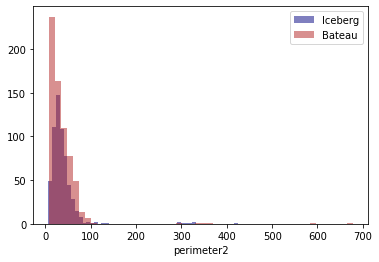

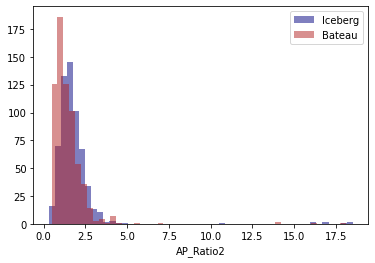

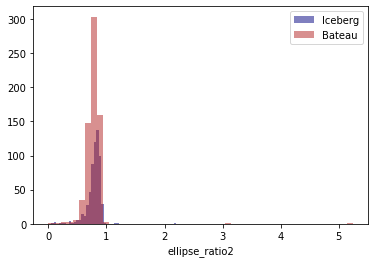

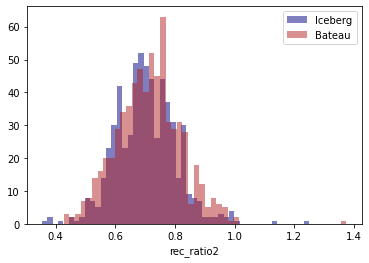

In [19]:
# plotting the variables
for i in [1,2] :
  
  for col in ['max_b'+str(i),'min_b'+str(i),'median_b'+str(i),'mean_b'+str(i),'argmax_b'+str(i),'argmin_b'+str(i),'variance_b'+str(i),
              
              'max_of_contour_b'+str(i),'min_of_contour_b'+str(i),'median_of_contour_b'+str(i),'mean_of_contour_b'+str(i),

              'argmax_of_contour_b'+str(i),'argmin_of_contour_b'+str(i),'variance_of_contour_b'+str(i),

              'area'+str(i),'perimeter'+str(i),'AP_Ratio'+str(i),'ellipse_ratio'+str(i),'rec_ratio'+str(i)]:  

    plot_features(df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')],col)

## Matrice de corrélation

In [20]:
df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].head()

,band_1,band_2,is_iceberg,inc_angle,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
486,"[0.3355775335842331, 0.33493948584738453, 0.33...","[0.31956969827674825, 0.31928660892872895, 0.3...",0,43.2220,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556,0.673037,0.279277,0.321376,0.329599,3030,5561,0.001465,0.700185,0.269896,0.298510,0.306583,2955,5562,0.001615,0.195340,0.093825,0.125055,0.132238,34,0,0.000684,0.228455,0.098129,0.135163,0.144050,52,...,0.277594,0.275361,0.273914,0.272672,0.272270,0.272346,0.272795,0.273271,0.285061,0.297593,0.304712,0.309312,0.314103,0.318610,0.322357,0.328036,0.333159,0.337030,0.340405,0.342629,0.343474,0.343355,0.342245,0.339654,0.334079,0.328502,0.321347,0.311842,0.304773,0.302921,0.301306,0.300452,0.300241,0.300625,0.301784,0.303218,0.304376,0.305305,0.305939,0.306295
760,"[0.2513751371634836, 0.25150778696110543, 0.25...","[0.25079425332244637, 0.2508456971250878, 0.25...",1,44.6187,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622,0.718197,0.241889,0.271650,0.279537,2739,4875,0.001983,0.621322,0.232657,0.252365,0.259993,2739,5025,0.001306,0.205473,0.079472,0.110376,0.118565,67,0,0.001053,0.191968,0.068797,0.093696,0.106765,30,...,0.251831,0.251831,0.251858,0.251919,0.252005,0.252128,0.252195,0.252233,0.252165,0.252005,0.251656,0.251065,0.250180,0.249162,0.248041,0.246476,0.245619,0.244926,0.244322,0.244022,0.243974,0.244250,0.244797,0.245676,0.246487,0.247279,0.248176,0.248949,0.249578,0.250042,0.250302,0.250399,0.250352,0.250216,0.250039,0.249808,0.249564,0.249331,0.249152,0.249076
1502,"[0.3723931654571044, 0.37171637732336404, 0.37...","[0.3933240483745459, 0.3921672755482756, 0.390...",1,36.1049,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500,0.673343,0.338697,0.395267,0.403209,2358,3451,0.001360,0.563227,0.332550,0.401291,0.404027,2358,4197,0.000723,0.130953,0.038285,0.066682,0.069859,63,0,0.000587,0.054072,0.027692,0.035979,0.037507,44,...,0.389890,0.391266,0.392397,0.394017,0.395708,0.398284,0.400580,0.402950,0.406472,0.407729,0.408295,0.408489,0.408351,0.408471,0.408958,0.410483,0.412870,0.414363,0.415518,0.416173,0.416373,0.416125,0.415717,0.415040,0.414227,0.413139,0.412093,0.410297,0.408118,0.405589,0.402837,0.400302,0.398584,0.397270,0.396212,0.395558,0.395454,0.395679,0.396109,0.396534
682,"[0.22155687429877088, 0.2218296214479607, 0.22...","[0.23321872433837001, 0.23340868623025782, 0.2...",1,39.5450,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000,0.610324,0.212600,0.235882,0.240507,2737,5566,0.000888,0.473743,0.223431,0.239144,0.242225,2662,5568,0.000381,0.199760,0.064064,0.097507,0.109619,59,0,0.001530,0.115416,0.033901,0.062868,0.064211,62,...,0.234789,0.235723,0.236750,0.237875,0.239024,0.240500,0.241943,0.242761,0.243402,0.243654,0.243478,0.242820,0.241647,0.239771,0.237902,0.236654,0.235668,0.234980,0.234741,0.234841,0.235253,0.235924,0.236597,0.237291,0.237999,0.238555,0.239242,0.239816,0.240303,0.240718,0.240965,0.241084,0.241112,0.241036,

In [21]:
df["ellipse_ratio1"]=pd.to_numeric(df["ellipse_ratio1"],errors = 'coerce')
df["ellipse_ratio2"]=pd.to_numeric(df["ellipse_ratio2"],errors = 'coerce')

In [22]:
df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 486 to 791
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   band_1                  1283 non-null   object 
 1   band_2                  1283 non-null   object 
 2   is_iceberg              1283 non-null   int64  
 3   inc_angle               1189 non-null   float64
 4   area1                   1283 non-null   float64
 5   perimeter1              1283 non-null   float64
 6   AP_Ratio1               1283 non-null   float64
 7   ellipse_ratio1          1278 non-null   float64
 8   rec_ratio1              1283 non-null   float64
 9   area2                   1283 non-null   float64
 10  perimeter2              1283 non-null   float64
 11  AP_Ratio2               1283 non-null   float64
 12  ellipse_ratio2          1274 non-null   float64
 13  rec_ratio2              1283 non-null   float64
 14  max_b1                  1283 non-null  

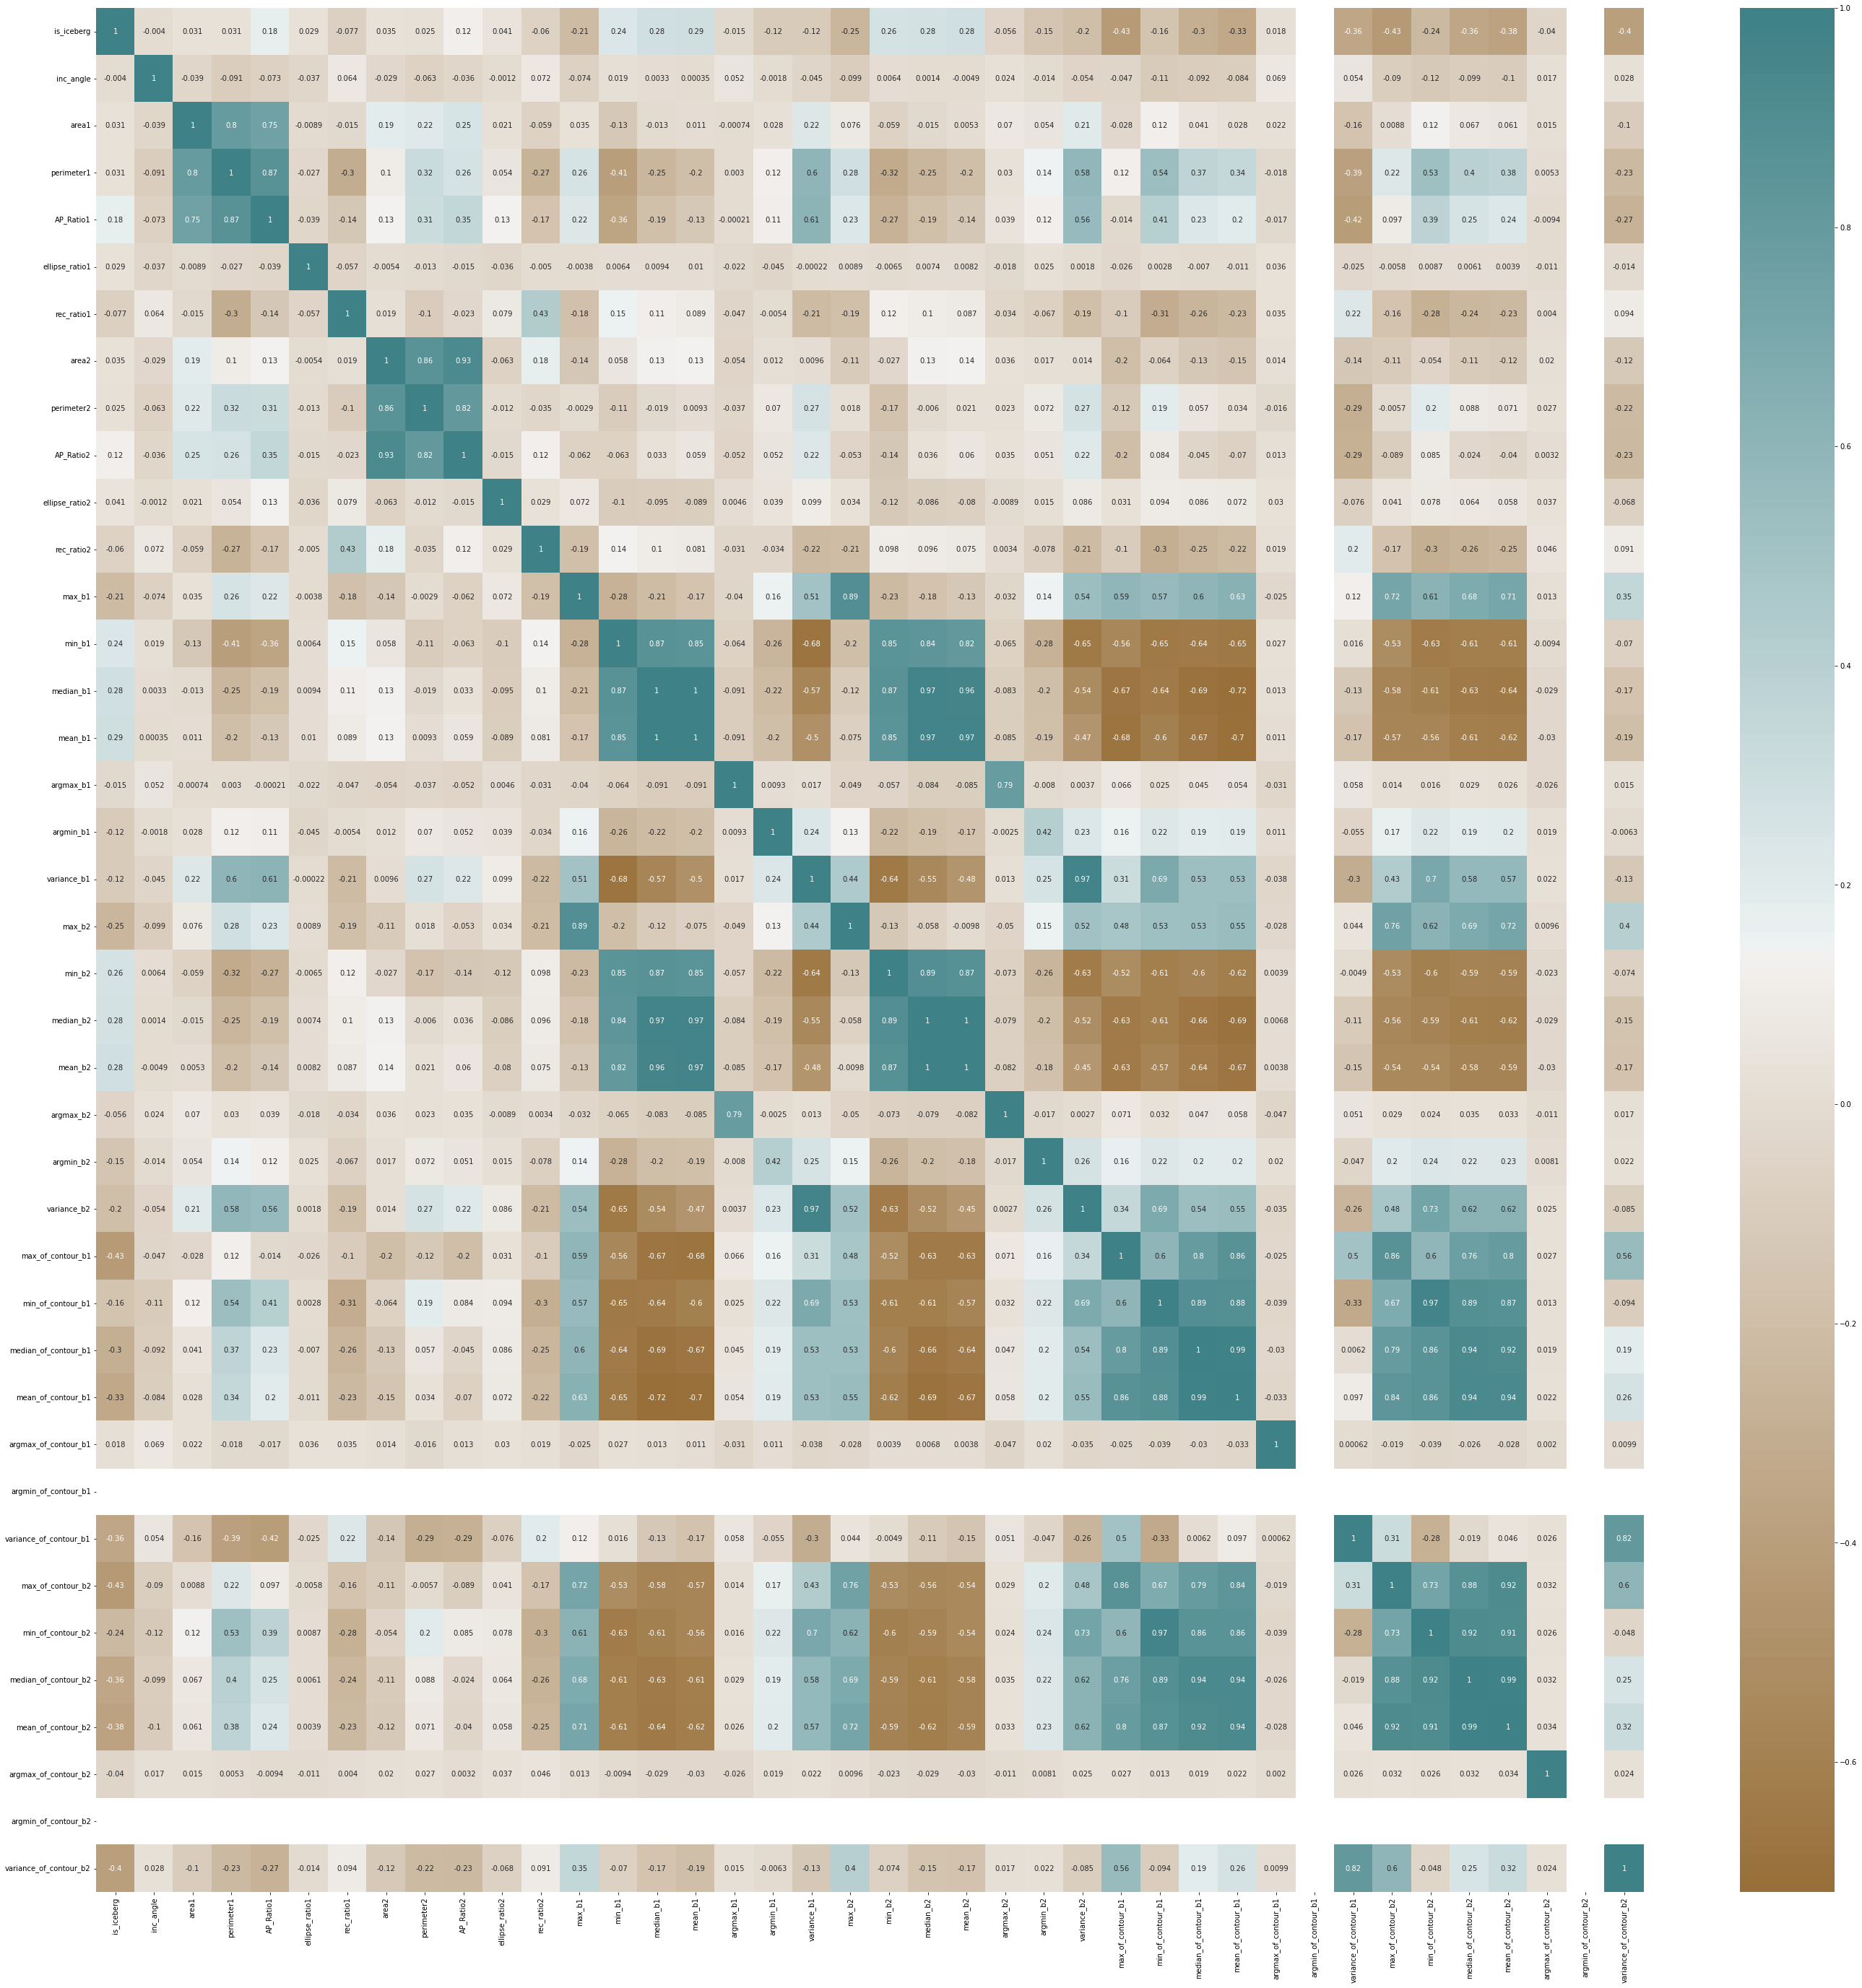

In [23]:
stats_corr = df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).corr()
plt.figure(figsize = (48,48))
ax = sns.heatmap(stats_corr, annot = True, cmap = sns.diverging_palette(50, 200, n=200))

# Results

## On statistics only

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

# selecting the prediction target and the model features
dfnew = df.dropna()
y = dfnew["is_iceberg"]
X_stats = dfnew.loc[:,['max_b1','min_b1','median_b1','mean_b1','variance_b1','max_b2','min_b2','median_b2','mean_b2','variance_b2',
           'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
           'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
           'area1','perimeter1','AP_Ratio1','ellipse_ratio1','rec_ratio1',
           'area2','perimeter2','AP_Ratio2','ellipse_ratio2','rec_ratio2']]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)

### DecisionTreeClassifier

In [25]:
X_stats

,max_b1,min_b1,median_b1,mean_b1,variance_b1,max_b2,min_b2,median_b2,mean_b2,variance_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,variance_of_contour_b2,area1,perimeter1,AP_Ratio1,ellipse_ratio1,rec_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,rec_ratio2
486,0.673037,0.279277,0.321376,0.329599,0.001465,0.700185,0.269896,0.298510,0.306583,0.001615,0.195340,0.093825,0.125055,0.132238,0.000684,0.228455,0.098129,0.135163,0.144050,0.001216,55.5,44.870057,1.236905,0.659313,0.684716,40.0,38.627416,1.035534,0.593261,0.555556
760,0.718197,0.241889,0.271650,0.279537,0.001983,0.621322,0.232657,0.252365,0.259993,0.001306,0.205473,0.079472,0.110376,0.118565,0.001053,0.191968,0.068797,0.093696,0.106765,0.001246,39.5,28.727922,1.374969,0.855982,0.718182,46.0,30.142135,1.526103,0.738801,0.621622
1502,0.673343,0.338697,0.395267,0.403209,0.001360,0.563227,0.332550,0.401291,0.404027,0.000723,0.130953,0.038285,0.066682,0.069859,0.000587,0.054072,0.027692,0.035979,0.037507,0.000044,41.5,27.899495,1.487482,0.863344,0.658730,115.5,47.213203,2.446350,0.889706,0.687500
682,0.610324,0.212600,0.235882,0.240507,0.000888,0.473743,0.223431,0.239144,0.242225,0.000381,0.199760,0.064064,0.097507,0.109619,0.001530,0.115416,0.033901,0.062868,0.064211,0.000513,22.0,19.656854,1.119202,0.726098,0.785714,21.0,19.656854,1.068330,0.735465,0.750000
1324,0.729472,0.342745,0.403030,0.405857,0.000748,0.679161,0.300586,0.400766,0.402461,0.000596,0.199295,0.055931,0.089024,0.103756,0.002067,0.167710,0.047675,0.073733,0.085875,0.001324,12.5,18.242641,0.685208,0.638965,0.542965,18.5,23.899495,0.774075,0.764474,0.573661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,0.697274,0.264571,0.336924,0.343749,0.001554,0.634686,0.301931,0.342558,0.348121,0.000980,0.228783,0.075358,0.105271,0.114320,0.001412,0.178553,0.051057,0.069043,0.083454,0.001075,44.5,33.899495,1.312704,0.769865,0.794643,37.5,27.071068,1.385243,0.778593,0.852273
23,0.719270,0.323183,0.408643,0.415837,0.001790,0.679861,0.323136,0.422969,0.427846,0.001389,0.185202,0.075717,0.101269,0.109775,0.000783,0.147353,0.061899,0.076332,0.084543,0.000398,89.5,42.384776,2.111607,0.846210,0.662963,107.0,45.798990,2.336296,0.804830,0.664545
539,0.697369,0.130828,0.232292,0.260549,0.008360,0.715803,0.151969,0.237975,0.266200,0.007738,0.194314,0.113266,0.139556,0.144230,0.000485,0.188431,0.107120,0.131772,0.135260,0.000495,270.0,72.627417,3.717604,0.880999,0.784672,245.0,71.455844,3.428691,0.914600,0.774758
5,0.723313,0.243386,0.284721,0.298626,0.003708,0.682240,0.264950,0.294131,0.307377,0.002784,0.209158,0.084561,0.113179,0.126423,0.001150,0.211226,0.074174,0.100313,0.110933,0.001227,86.5,36.384776,2.377368,0.960494,0.757723,88.5,37.213203,2.378188,0.954217,0.775243


--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.831
--- Cross Validation Report ---
Mean accuracy score 0.822 with std 0.007
Mean f1 score 0.824 with std 0.008
Mean precision score 0.848 with std 0.002
Mean recall score 0.802 with std 0.013
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.786
 f1 : 0.785
 precision : 0.782
 recall : 0.788
Confusion matrix for the test sample :


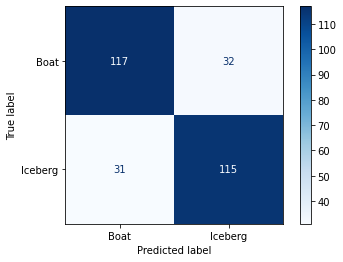

In [26]:
df_stats = dfnew.loc[:,['is_iceberg',
            'max_b1','min_b1','median_b1','mean_b1','variance_b1','max_b2','min_b2','median_b2','mean_b2','variance_b2',
            'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
            'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
            'area1','perimeter1','AP_Ratio1','ellipse_ratio1','rec_ratio1',
            'area2','perimeter2','AP_Ratio2','ellipse_ratio2','rec_ratio2']]
er = EvaluateAndReport(df_stats, X_train, X_test, y_train, y_test)

          
param_grid = [{
    'min_samples_leaf': [10],
    'max_features': [None]
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)

In [27]:
er.cross_proba_report()

--- Cross Validation with 0.5 Threshold Report ---
 accuracy : 0.82
 f1 : 0.822
 precision : 0.844
 recall : 0.802


--- Precision Recall Curves ---


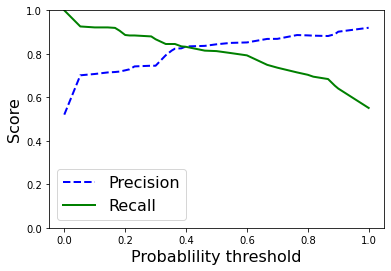

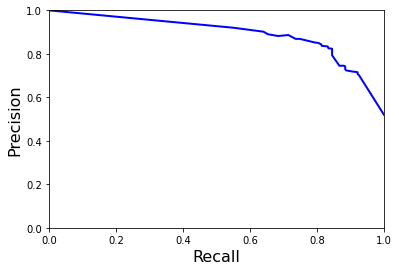

In [28]:
er.plot_precision_recall()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.614
--- Cross Validation Report ---
Mean accuracy score 0.627 with std 0.037
Mean f1 score 0.63 with std 0.032
Mean precision score 0.653 with std 0.044
Mean recall score 0.61 with std 0.025
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.675
 f1 : 0.662
 precision : 0.681
 recall : 0.644
Confusion matrix for the test sample :


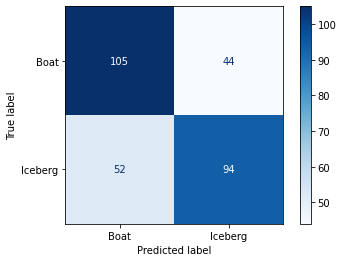

In [29]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)

###C-support Vector

--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 0.001} with f1 score 0.685
--- Cross Validation Report ---
Mean accuracy score 0.52 with std 0.0
Mean f1 score 0.685 with std 0.0
Mean precision score 0.52 with std 0.0
Mean recall score 1.0 with std 0.0
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :


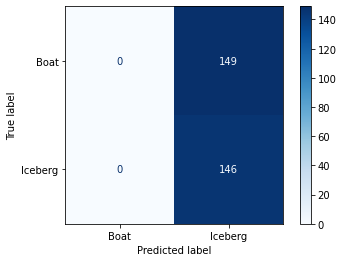

In [30]:
from sklearn.svm import SVC


param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]


er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train

er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)



In [31]:
#er.grid_cross_test_report(SVC(kernel='linear'), param_grid)

--- Grid Search Report ---
Best parameters for SVC(kernel='sigmoid') :
 {'C': 0.001} with f1 score 0.685
--- Cross Validation Report ---
Mean accuracy score 0.52 with std 0.0
Mean f1 score 0.685 with std 0.0
Mean precision score 0.52 with std 0.0
Mean recall score 1.0 with std 0.0
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :


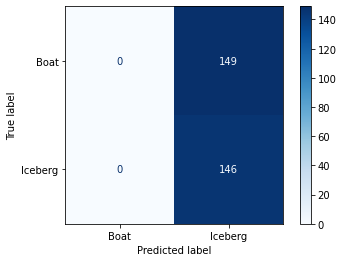

In [32]:
er.grid_cross_test_report(SVC(kernel='sigmoid', gamma='scale'), param_grid)

###Gaussian Process

--- Cross Validation Report ---
Mean accuracy score 0.663 with std 0.019
Mean f1 score 0.664 with std 0.01
Mean precision score 0.693 with std 0.033
Mean recall score 0.638 with std 0.008
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.722
 f1 : 0.723
 precision : 0.713
 recall : 0.733
Confusion matrix for the test sample :


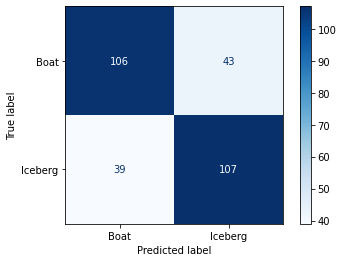

In [33]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))

### Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 100} with f1 score 0.868
--- Cross Validation Report ---
Mean accuracy score 0.854 with std 0.018
Mean f1 score 0.862 with std 0.018
Mean precision score 0.848 with std 0.018
Mean recall score 0.876 with std 0.028
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.847
 f1 : 0.853
 precision : 0.814
 recall : 0.897
Confusion matrix for the test sample :


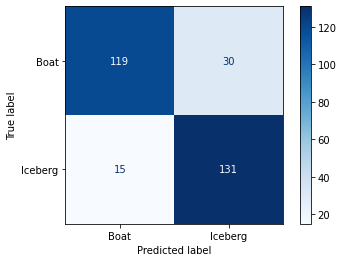

In [34]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{
    'min_samples_leaf': range(2,15,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]
er.grid_cross_test_report(RandomForestClassifier(), param_grid)

###Neural net

--- Grid Search Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overfl

Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 700, 'solver': 'adam'} with f1 score 0.794
--- Cross Validation Report ---
Mean accuracy score 0.765 with std 0.006
Mean f1 score 0.768 with std 0.02
Mean precision score 0.793 with std 0.035
Mean recall score 0.752 with std 0.074
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.756
 f1 : 0.731
 precision : 0.803
 recall : 0.671
Confusion matrix for the test sample :


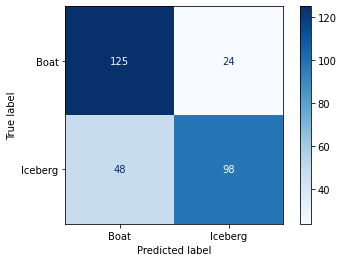

In [35]:
from sklearn.neural_network import MLPClassifier

param_grid = [{'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [700],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}]
er.grid_cross_test_report(MLPClassifier(), param_grid)

### Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.841 with std 0.007
Mean f1 score 0.849 with std 0.009
Mean precision score 0.842 with std 0.006
Mean recall score 0.856 with std 0.023
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.824
 f1 : 0.83
 precision : 0.794
 recall : 0.87
Confusion matrix for the test sample :


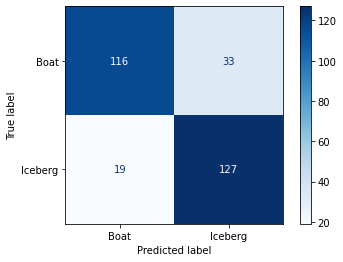

In [36]:
from sklearn.ensemble import AdaBoostClassifier

er.cross_test_report(AdaBoostClassifier())

## On PCA data only

In [37]:
# Applying a PCA and saving for differents PCs

# I could have used a pipeline...
def get_pca_df(df, X, pcs):
  X_std = StandardScaler().fit_transform(X)
  pca = PCA(pcs).fit(X_std)
  res = pd.DataFrame(pca.transform(X_std),columns=['PC%s' % _ for _ in range(pcs)], index=df.index)
  res = res.join(df['is_iceberg'])
  res = res.dropna()
  return res

In [38]:
pca_5 = get_pca_df(df, naive_base_pretreated, 5)
pca_10 = get_pca_df(df, naive_base_pretreated, 10)
pca_20 = get_pca_df(df, naive_base_pretreated, 20)
pca_50 = get_pca_df(df, naive_base_pretreated, 50)
pca_100 = get_pca_df(df, naive_base_pretreated, 100)
pca_200 = get_pca_df(df, naive_base_pretreated, 200)
pca_500 = get_pca_df(df, naive_base_pretreated, 500)

In [39]:
pca_5

,PC0,PC1,PC2,PC3,PC4,is_iceberg
486,-21.919239,-1.882014,-18.766076,10.752720,-7.173111,0
760,-87.599313,-6.143001,-7.194587,7.096251,-2.165415,1
1502,91.491704,14.523974,-2.698913,0.417311,-1.733246,1
682,-121.188753,-20.697875,-11.664893,-9.818651,1.889821,1
1324,95.325481,-5.333014,-6.871300,1.342656,3.656495,1
...,...,...,...,...,...,...
23,114.192423,7.449332,19.008517,-4.315867,-4.202578,1
539,-103.276899,51.265882,2.980151,-4.858848,-27.042109,0
142,181.681898,5.511688,-5.870333,-2.469848,1.215879,0
5,-46.620637,21.118767,-10.131134,-8.705803,-5.253679,1


### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.62
--- Cross Validation Report ---
Mean accuracy score 0.664 with std 0.064
Mean f1 score 0.627 with std 0.073
Mean precision score 0.659 with std 0.075
Mean recall score 0.601 with std 0.083
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.695
 f1 : 0.682
 precision : 0.7
 recall : 0.665
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.638
--- Cross Validation Report ---
Mean accuracy score 0.683 with std 0.062
Mean f1 score 0.653 with std 0.073
Mean precision score 0.674 with std 0.07
Mean recall score 0.636 with std 0.089
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.657
 f1 : 0.613
 precision : 0.69
 recall : 0.551
Confusion matrix for the test sample :
--- Grid Search Report --

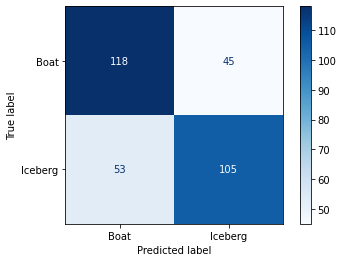

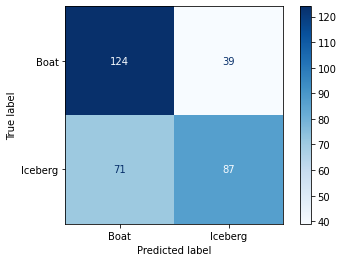

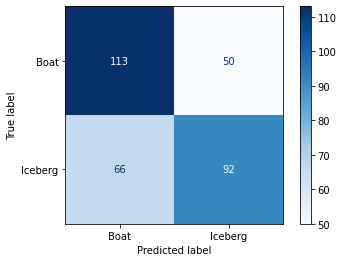

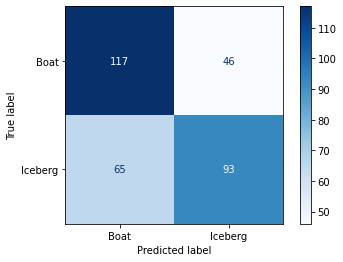

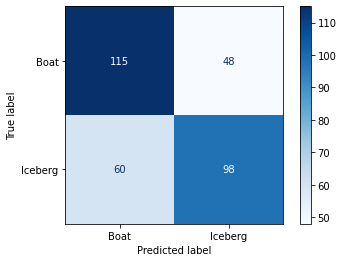

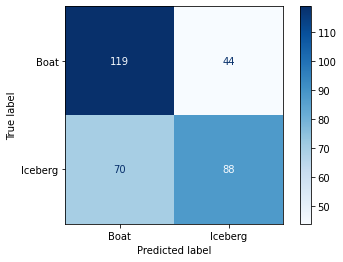

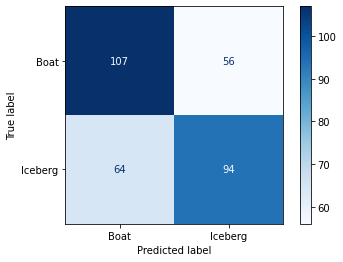

In [40]:
param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 3

train_scores = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores.append(er.best_scores_t)

In [41]:
train_scores

[{'accuracy': 0.664, 'f1': 0.627, 'precision': 0.659, 'recall': 0.601},
 {'accuracy': 0.683, 'f1': 0.653, 'precision': 0.674, 'recall': 0.636},
 {'accuracy': 0.683, 'f1': 0.653, 'precision': 0.68, 'recall': 0.632},
 {'accuracy': 0.683, 'f1': 0.652, 'precision': 0.675, 'recall': 0.637},
 {'accuracy': 0.672, 'f1': 0.633, 'precision': 0.669, 'recall': 0.603},
 {'accuracy': 0.656, 'f1': 0.632, 'precision': 0.638, 'recall': 0.629},
 {'accuracy': 0.612, 'f1': 0.576, 'precision': 0.597, 'recall': 0.559}]

In [42]:
x_plot = [5, 10, 20, 50, 100, 200, 500]
y_plot1 = [a.get('accuracy') for a in train_scores]
y_plot2 = [a.get('f1') for a in train_scores]
y_plot3 = [a.get('precision') for a in train_scores]
y_plot4 = [a.get('recall') for a in train_scores]

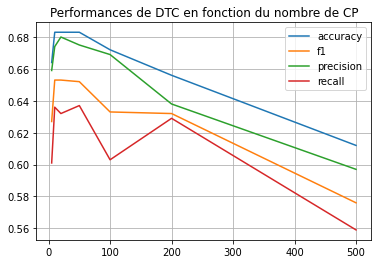

In [43]:
plt.plot(x_plot, y_plot1, label='accuracy')
plt.plot(x_plot, y_plot2, label='f1')
plt.plot(x_plot, y_plot3, label='precision')
plt.plot(x_plot, y_plot4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.638
--- Cross Validation Report ---
Mean accuracy score 0.675 with std 0.045
Mean f1 score 0.637 with std 0.055
Mean precision score 0.672 with std 0.053
Mean recall score 0.609 with std 0.077
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.66
 f1 : 0.635
 precision : 0.674
 recall : 0.601
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 12} with f1 score 0.638
--- Cross Validation Report ---
Mean accuracy score 0.693 with std 0.038
Mean f1 score 0.638 with std 0.047
Mean precision score 0.724 with std 0.07
Mean recall score 0.579 with std 0.072
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.698
 f1 : 0.66
 precision : 0.74
 recall : 0.595
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_nei

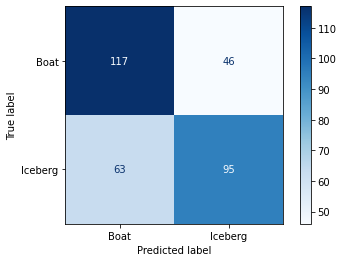

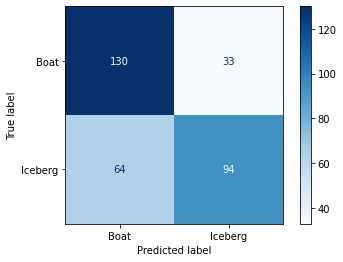

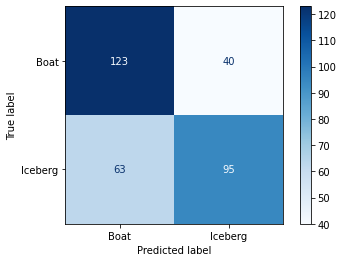

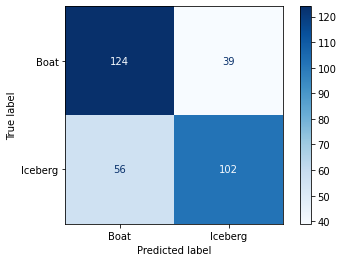

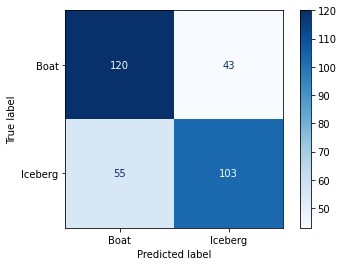

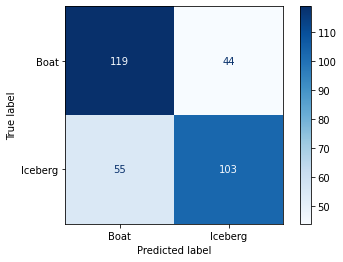

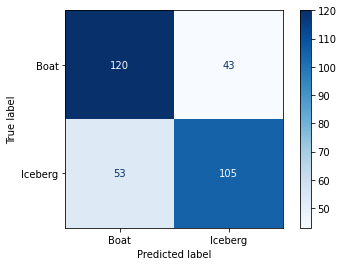

In [44]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3

train_scores_knn = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [45]:
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

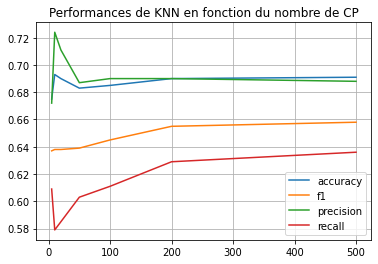

In [46]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

###C-support Vector


--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.677
--- Cross Validation Report ---
Mean accuracy score 0.703 with std 0.054
Mean f1 score 0.681 with std 0.059
Mean precision score 0.692 with std 0.073
Mean recall score 0.678 with std 0.083
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.676
 f1 : 0.665
 precision : 0.678
 recall : 0.652
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.697
--- Cross Validation Report ---
Mean accuracy score 0.727 with std 0.051
Mean f1 score 0.697 with std 0.05
Mean precision score 0.735 with std 0.073
Mean recall score 0.667 with std 0.051
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.723
 f1 : 0.694
 precision : 0.759
 recall : 0.639
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.732
--- Cross Validation Report ---
Mean ac

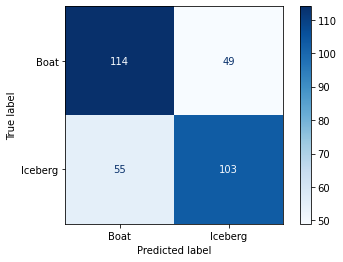

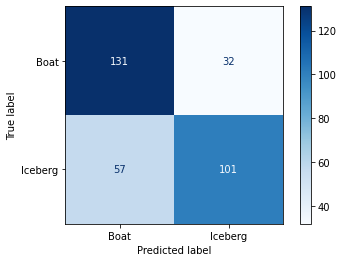

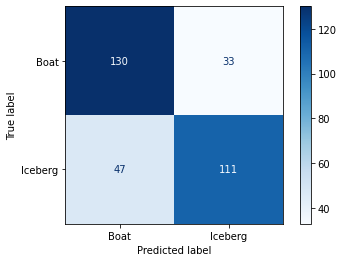

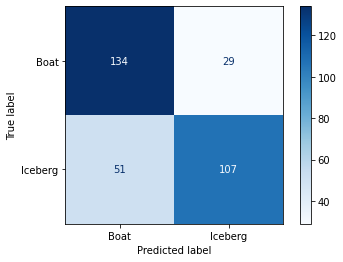

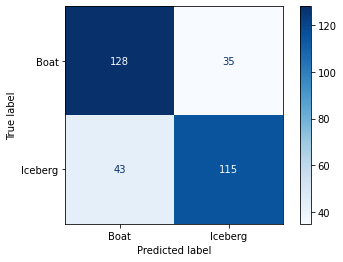

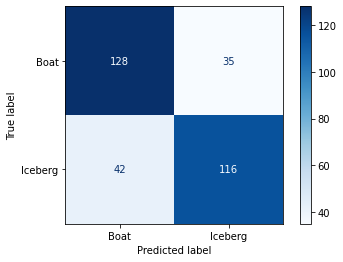

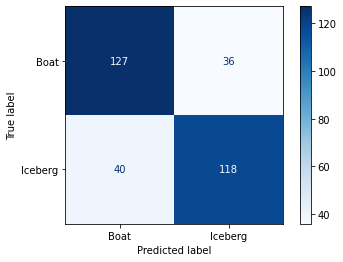

In [47]:
param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]


er.cv_cv = 3
train_scores_svc= []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)
  train_scores_svc.append(er.best_scores_t)

In [48]:
y_p1 = [a.get('accuracy') for a in train_scores_svc]
y_p2 = [a.get('f1') for a in train_scores_svc]
y_p3 = [a.get('precision') for a in train_scores_svc]
y_p4 = [a.get('recall') for a in train_scores_svc]

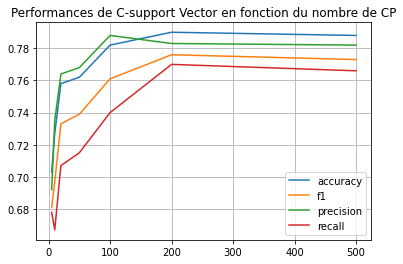

In [49]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de C-support Vector en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Gaussian Process

--- Cross Validation Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Mean accuracy score 0.63 with std 0.06
Mean f1 score 0.557 with std 0.193
Mean precision score 0.56 with std 0.197
Mean recall score 0.556 with std 0.194
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.648
 f1 : 0.644
 precision : 0.642
 recall : 0.646
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.704 with std 0.051
Mean f1 score 0.676 with std 0.057
Mean precision score 0.701 with std 0.07
Mean recall score 0.658 with std 0.076
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.692
 f1 : 0.684
 precision : 0.69
 recall : 0.677
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.684 with std 0.045
Mean f1 score 0.675 with std 0.041
Mean precision score 0.659 with std 0.055
Mean recall score 0.697 with std 0.065
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.701
 f1 : 0.702
 precision : 0.689
 recall : 0.715
Confusion matrix for the test

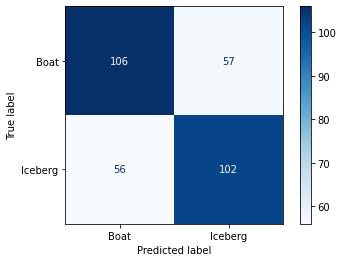

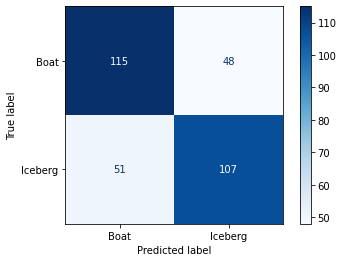

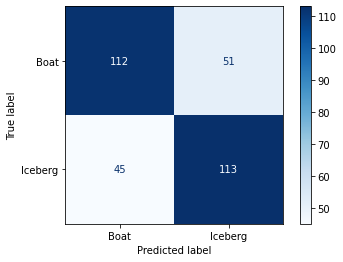

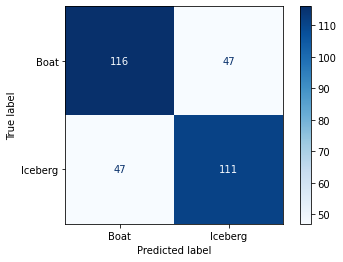

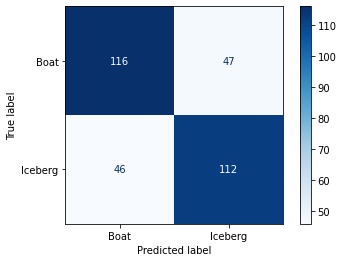

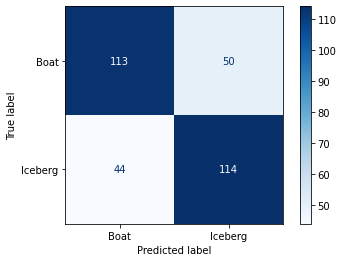

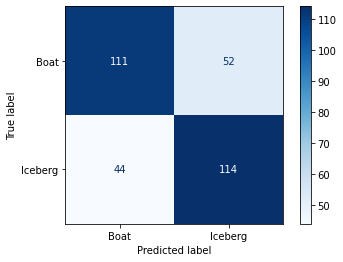

In [50]:
train_scores_GP = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))
  train_scores_GP.append(er.best_scores_t)

In [51]:
y_p1 = [a.get('accuracy') for a in train_scores_GP]
y_p2 = [a.get('f1') for a in train_scores_GP]
y_p3 = [a.get('precision') for a in train_scores_GP]
y_p4 = [a.get('recall') for a in train_scores_GP]

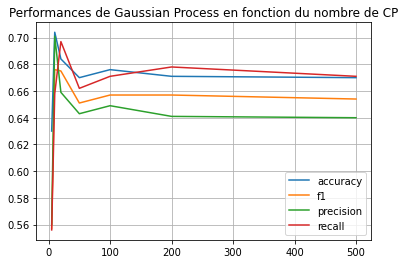

In [52]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Gaussian Process en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100} with f1 score 0.697
--- Cross Validation Report ---
Mean accuracy score 0.711 with std 0.042
Mean f1 score 0.687 with std 0.05
Mean precision score 0.704 with std 0.054
Mean recall score 0.678 with std 0.083
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.72
 f1 : 0.719
 precision : 0.71
 recall : 0.728
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 100} with f1 score 0.72
--- Cross Validation Report ---
Mean accuracy score 0.741 with std 0.041
Mean f1 score 0.715 with std 0.049
Mean precision score 0.743 with std 0.05
Mean recall score 0.691 with std 0.068
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.732
 f1 : 0.707
 precision : 0.765
 recall : 0.658
Confusion matrix f

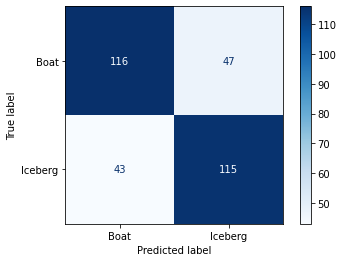

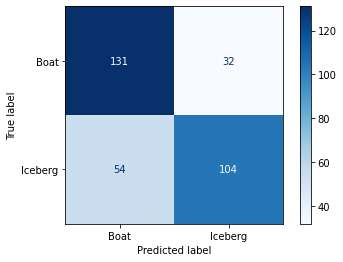

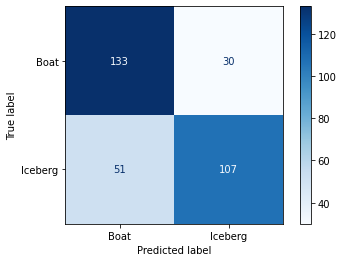

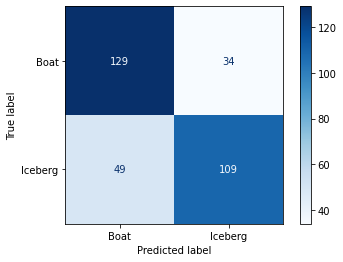

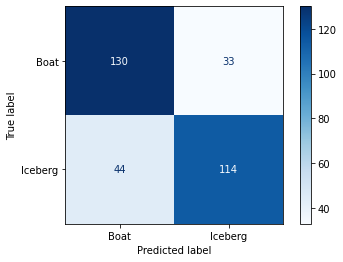

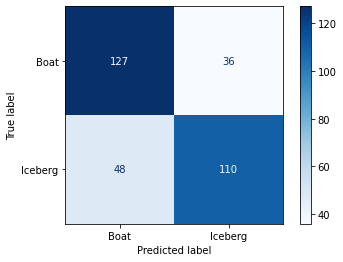

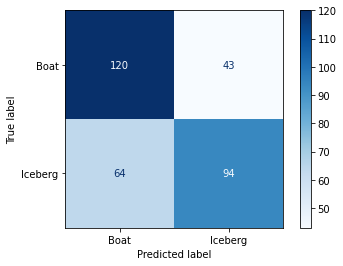

In [53]:
param_grid = [{
    'min_samples_leaf': range(2,12,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]

er.cv_cv = 3
train_scores_RF= []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(RandomForestClassifier(), param_grid)
  train_scores_RF.append(er.best_scores_t)

In [54]:
y_p1 = [a.get('accuracy') for a in train_scores_RF]
y_p2 = [a.get('f1') for a in train_scores_RF]
y_p3 = [a.get('precision') for a in train_scores_RF]
y_p4 = [a.get('recall') for a in train_scores_RF]

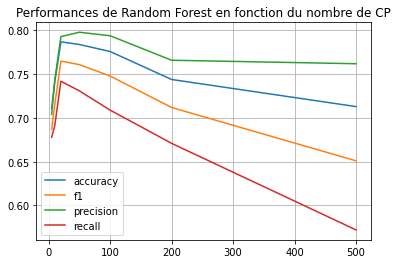

In [55]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Random Forest en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Neural Test

--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.612
--- Cross Validation Report ---
Mean accuracy score 0.667 with std 0.045
Mean f1 score 0.648 with std 0.056
Mean precision score 0.645 with std 0.047
Mean recall score 0.653 with std 0.076
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.642
 f1 : 0.637
 precision : 0.635
 recall : 0.639
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.632
--- Cross Validation Report ---
Mean accuracy score 0.661 with std 0.048
Mean f1 score 0.636 with std 0.057
Mean precision score 0.642 with std 0.051
Mean recall score 0.633 with std 0.076
--- Tes

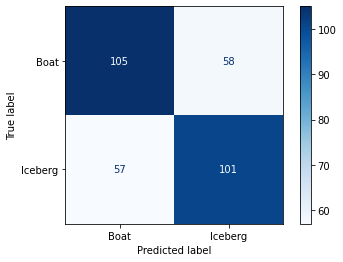

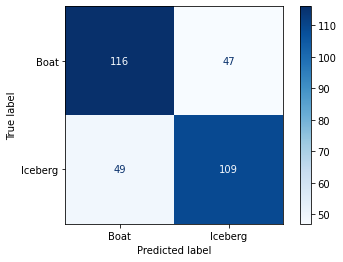

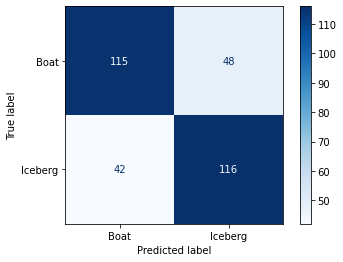

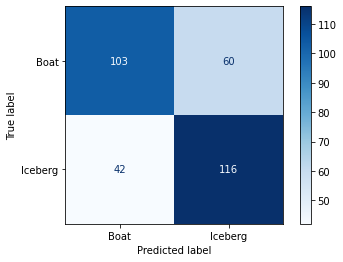

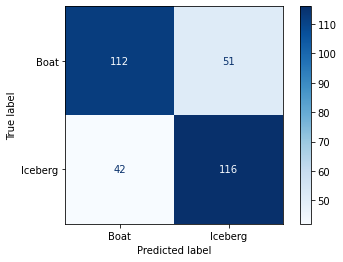

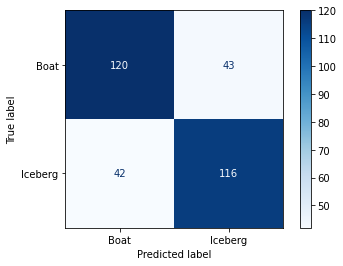

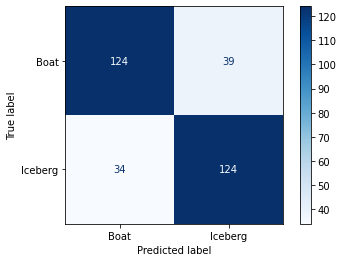

In [56]:
param_grid = [{'activation': ['tanh'],
               'alpha': [0.0001,0.005],
               'hidden_layer_sizes': [(150, 100, 50)],
               'learning_rate': ['adaptive'],
               'max_iter': [400],
               'solver': ['adam']}]

er.cv_cv = 3
train_scores_NeuralTest= []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(MLPClassifier(), param_grid)
  train_scores_NeuralTest.append(er.best_scores_t)

In [57]:
y_p1 = [a.get('accuracy') for a in train_scores_NeuralTest]
y_p2 = [a.get('f1') for a in train_scores_NeuralTest]
y_p3 = [a.get('precision') for a in train_scores_NeuralTest]
y_p4 = [a.get('recall') for a in train_scores_NeuralTest]

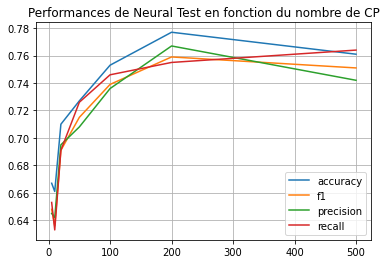

In [58]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Neural Test en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.668 with std 0.047
Mean f1 score 0.661 with std 0.05
Mean precision score 0.641 with std 0.055
Mean recall score 0.691 with std 0.089
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.632
 f1 : 0.649
 precision : 0.612
 recall : 0.69
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.7 with std 0.048
Mean f1 score 0.679 with std 0.054
Mean precision score 0.683 with std 0.053
Mean recall score 0.678 with std 0.066
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.698
 f1 : 0.686
 precision : 0.702
 recall : 0.671
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.712 with std 0.038
Mean f1 score 0.69 with std 0.039
Mean precision score 0.702 with std 0.05
Mean recall score 0.68 with std 0.046
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.732
 f1 : 0.721
 precision : 0.74
 recall : 0.703


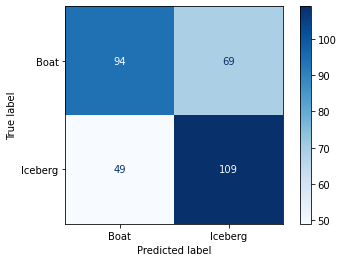

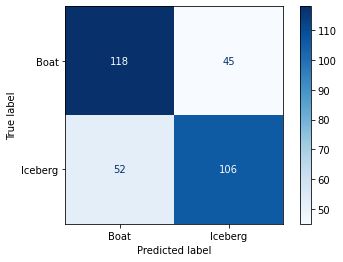

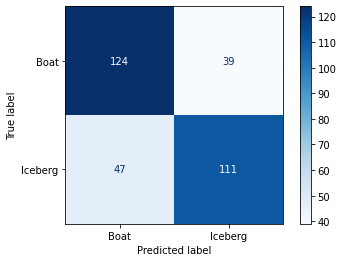

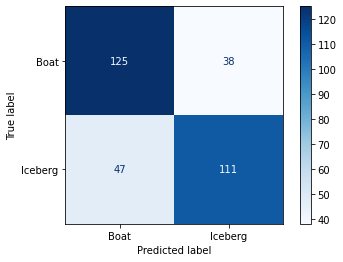

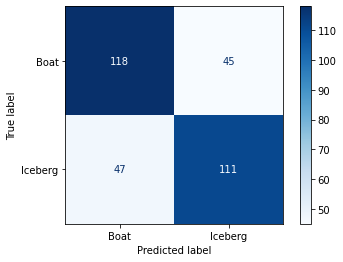

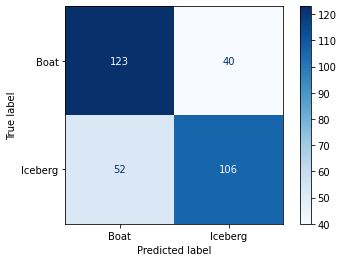

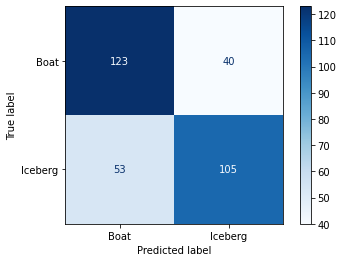

In [59]:
er.cv_cv = 3

train_scores_Adaboost = []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(AdaBoostClassifier())
  train_scores_Adaboost.append(er.best_scores_t)

In [60]:
y_p1 = [a.get('accuracy') for a in train_scores_Adaboost]
y_p2 = [a.get('f1') for a in train_scores_Adaboost]
y_p3 = [a.get('precision') for a in train_scores_Adaboost]
y_p4 = [a.get('recall') for a in train_scores_Adaboost]

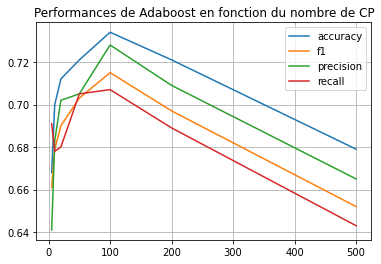

In [61]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Adaboost en fonction du nombre de CP')
plt.grid(True)
plt.show()

## On PCA and statistics

In [62]:
df_stats = df_stats.loc[:,~df_stats.columns.duplicated()]
df_5 = df_stats.join(pca_5.drop('is_iceberg',axis=1)).dropna()
df_20 = df_stats.join(pca_20.drop('is_iceberg',axis=1)).dropna()
df_50 = df_stats.join(pca_50.drop('is_iceberg',axis=1)).dropna()
df_100 = df_stats.join(pca_100.drop('is_iceberg',axis=1)).dropna()

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.822
--- Cross Validation Report ---
Mean accuracy score 0.822 with std 0.037
Mean f1 score 0.828 with std 0.037
Mean precision score 0.832 with std 0.039
Mean recall score 0.826 with std 0.058
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.786
 f1 : 0.785
 precision : 0.782
 recall : 0.788
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.831
--- Cross Validation Report ---
Mean accuracy score 0.834 with std 0.024
Mean f1 score 0.84 with std 0.023
Mean precision score 0.849 with std 0.037
Mean recall score 0.832 with std 0.031
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.797
 f1 : 0.783
 precision : 0.831
 recall : 0.74
Confusion matrix for the test sample :
--- Grid Search Repo

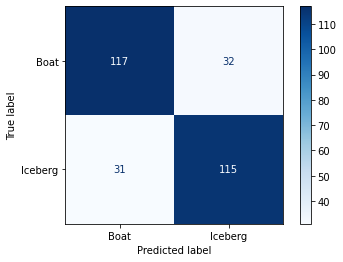

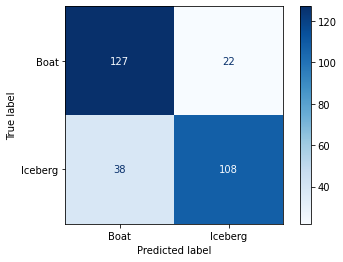

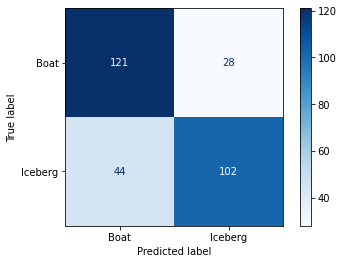

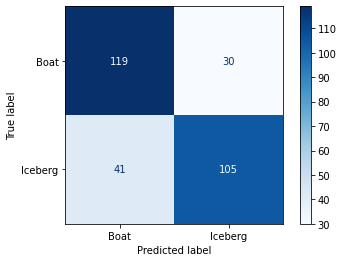

In [63]:
train_scores_mix = []

param_grid = [{
    'min_samples_leaf': [10],
    'max_features': [None]
}]

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop(['is_iceberg'],axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores_mix.append(er.best_scores_t)

In [64]:
x_p = [5, 20, 50, 100]
y1 = [a.get('accuracy') for a in train_scores_mix]
y2 = [a.get('f1') for a in train_scores_mix]
y3 = [a.get('precision') for a in train_scores_mix]
y4 = [a.get('recall') for a in train_scores_mix]

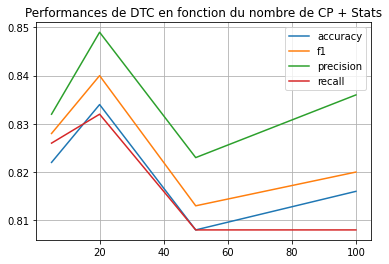

In [65]:
plt.plot(x_p, y1, label='accuracy')
plt.plot(x_p, y2, label='f1')
plt.plot(x_p, y3, label='precision')
plt.plot(x_p, y4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP + Stats')
plt.grid(True)
plt.show()

###KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 8} with f1 score 0.74
--- Cross Validation Report ---
Mean accuracy score 0.737 with std 0.04
Mean f1 score 0.74 with std 0.046
Mean precision score 0.761 with std 0.04
Mean recall score 0.723 with std 0.072
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.698
 f1 : 0.688
 precision : 0.705
 recall : 0.671
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 8} with f1 score 0.746
--- Cross Validation Report ---
Mean accuracy score 0.746 with std 0.043
Mean f1 score 0.752 with std 0.043
Mean precision score 0.765 with std 0.052
Mean recall score 0.743 with std 0.06
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.722
 f1 : 0.713
 precision : 0.729
 recall : 0.699
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighb

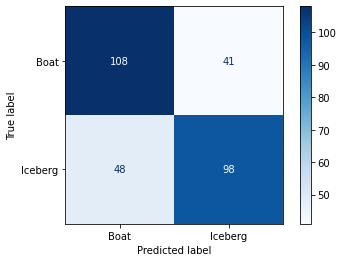

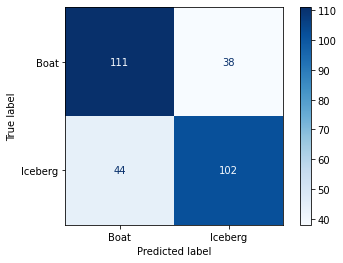

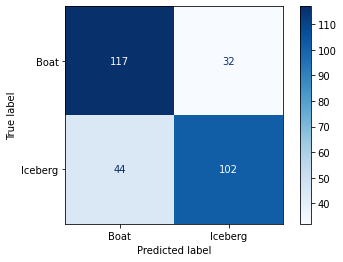

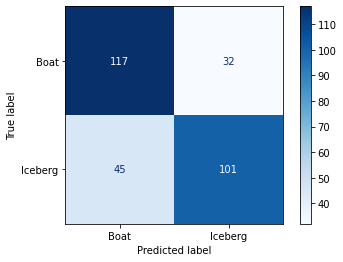

In [66]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3

train_scores_knn = []
for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [67]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

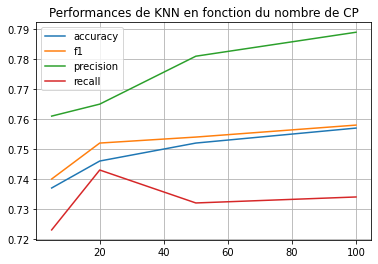

In [68]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

###C-support Vector


--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.691
--- Cross Validation Report ---
Mean accuracy score 0.533 with std 0.035
Mean f1 score 0.684 with std 0.006
Mean precision score 0.532 with std 0.032
Mean recall score 0.971 with std 0.087
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.701
--- Cross Validation Report ---
Mean accuracy score 0.54 with std 0.055
Mean f1 score 0.69 with std 0.013
Mean precision score 0.538 with std 0.05
Mean recall score 0.978 with std 0.067
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.698
--- Cross Validation Report ---
Mean accuracy

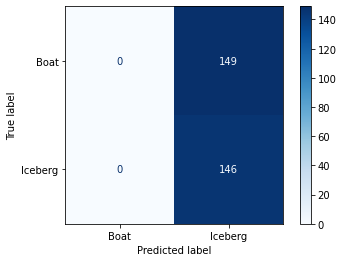

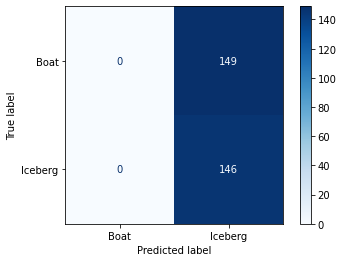

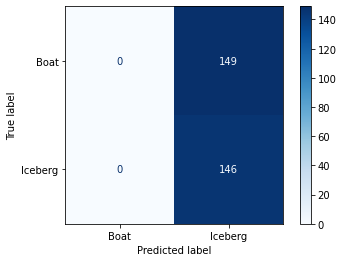

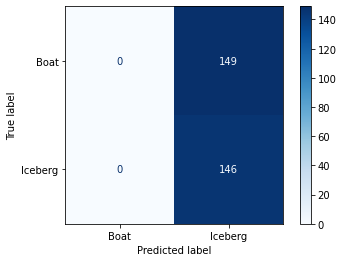

In [69]:
from sklearn.svm import SVC


param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]

er.cv_cv = 3

train_scores_SVC = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)
  train_scores_SVC.append(er.best_scores_t)

In [70]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_SVC]
y_p2 = [a.get('f1') for a in train_scores_SVC]
y_p3 = [a.get('precision') for a in train_scores_SVC]
y_p4 = [a.get('recall') for a in train_scores_SVC]

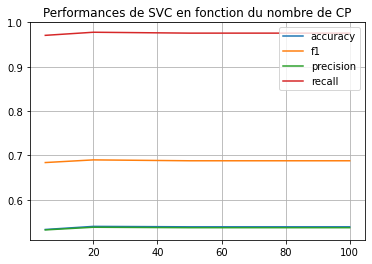

In [71]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de SVC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### Gaussian Process

--- Cross Validation Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning:

The optimal value found for dim

Mean accuracy score 0.726 with std 0.125
Mean f1 score 0.768 with std 0.071
Mean precision score 0.737 with std 0.135
Mean recall score 0.832 with std 0.095
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.78
 f1 : 0.777
 precision : 0.779
 recall : 0.774
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.742 with std 0.027
Mean f1 score 0.753 with std 0.03
Mean precision score 0.75 with std 0.032
Mean recall score 0.758 with std 0.05
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.702
 f1 : 0.701
 precision : 0.696
 recall : 0.705
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.727 with std 0.034
Mean f1 score 0.739 with std 0.036
Mean precision score 0.734 with std 0.035
Mean recall score 0.747 with std 0.056
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.715
 f1 : 0.725
 precision : 0.694
 recall : 0.76
Confusion matrix for the test

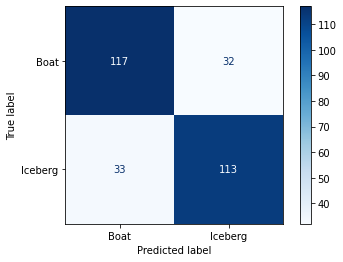

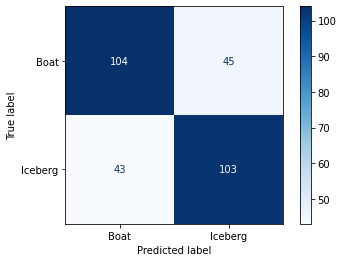

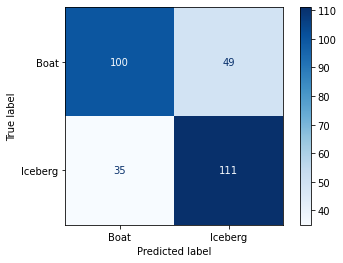

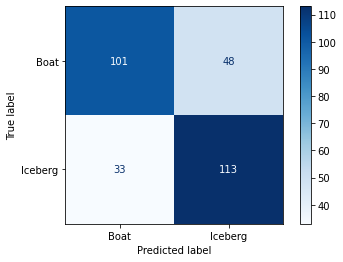

In [72]:
er.cv_cv = 3

train_scores_GP = []

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))
  train_scores_GP.append(er.best_scores_t)


In [73]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_GP]
y_p2 = [a.get('f1') for a in train_scores_GP]
y_p3 = [a.get('precision') for a in train_scores_GP]
y_p4 = [a.get('recall') for a in train_scores_GP]

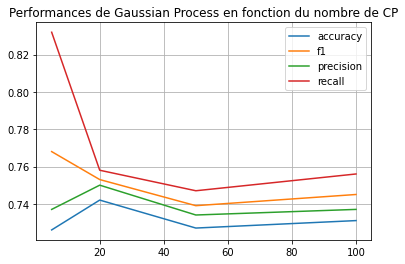

In [74]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Gaussian Process en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 100} with f1 score 0.871
--- Cross Validation Report ---
Mean accuracy score 0.857 with std 0.031
Mean f1 score 0.865 with std 0.03
Mean precision score 0.85 with std 0.033
Mean recall score 0.882 with std 0.051
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.851
 f1 : 0.856
 precision : 0.819
 recall : 0.897
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100} with f1 score 0.876
--- Cross Validation Report ---
Mean accuracy score 0.857 with std 0.027
Mean f1 score 0.865 with std 0.028
Mean precision score 0.847 with std 0.025
Mean recall score 0.887 with std 0.051
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.854
 f1 : 0.859
 precision : 0.824
 recall : 0.897
Confusion matri

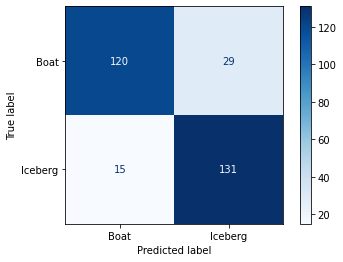

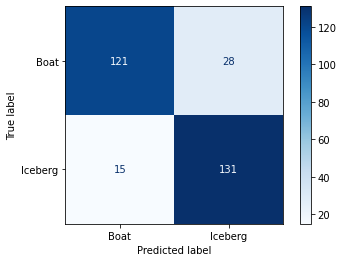

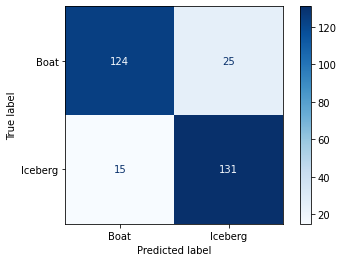

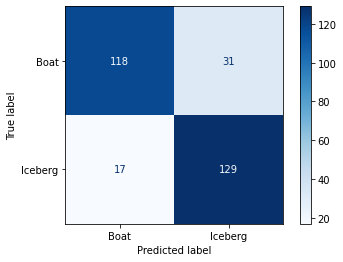

In [75]:
param_grid = [{
    'min_samples_leaf': range(2,4,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]


er.cv_cv = 3

train_scores_RF = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(RandomForestClassifier(), param_grid)
  train_scores_RF.append(er.best_scores_t)

In [76]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_RF]
y_p2 = [a.get('f1') for a in train_scores_RF]
y_p3 = [a.get('precision') for a in train_scores_RF]
y_p4 = [a.get('recall') for a in train_scores_RF]

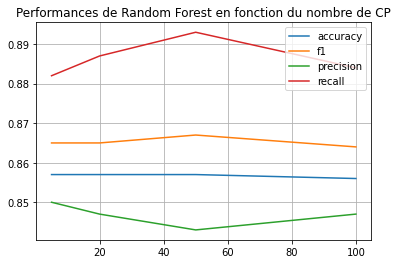

In [77]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Random Forest en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Neural Net

In [78]:
from sklearn.neural_network import MLPClassifier

--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.758
--- Cross Validation Report ---
Mean accuracy score 0.757 with std 0.04
Mean f1 score 0.771 with std 0.037
Mean precision score 0.758 with std 0.044
Mean recall score 0.787 with std 0.048
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.769
 f1 : 0.776
 precision : 0.747
 recall : 0.808
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.795
--- Cross Validation Report ---
Mean accuracy score 0.797 with std 0.034
Mean f1 score 0.811 with std 0.032
Mean precision score 0.787 with std 0.038
Mean recall score 0.839 with std 0.049
--- Test

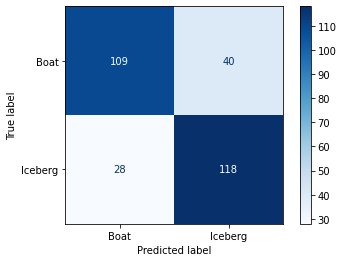

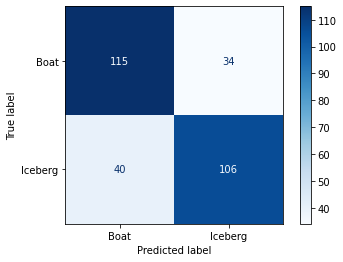

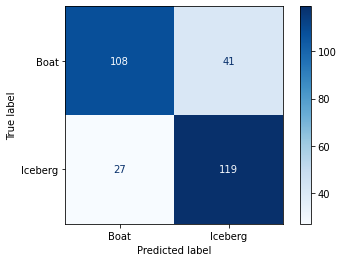

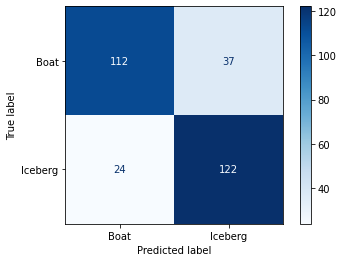

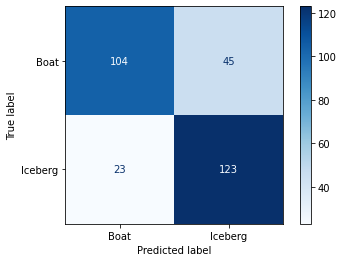

In [79]:
param_grid = [{'activation': ['tanh'],
               'alpha': [0.0001,0.005],
               'hidden_layer_sizes': [(150, 100, 50)],
               'learning_rate': ['adaptive'],
               'max_iter': [400],
               'solver': ['adam']}]



er.cv_cv = 3

train_scores_MLPC = []

er.grid_cross_test_report

df_500=df_stats.join(pca_100.drop('is_iceberg',axis=1)).dropna()

for dtset in [df_5, df_20, df_50, df_100, df_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(MLPClassifier(), param_grid)
  train_scores_MLPC.append(er.best_scores_t)

In [80]:
x_p = [5, 20, 50, 100, 500]
y_p1 = [a.get('accuracy') for a in train_scores_MLPC]
y_p2 = [a.get('f1') for a in train_scores_MLPC]
y_p3 = [a.get('precision') for a in train_scores_MLPC]
y_p4 = [a.get('recall') for a in train_scores_MLPC]

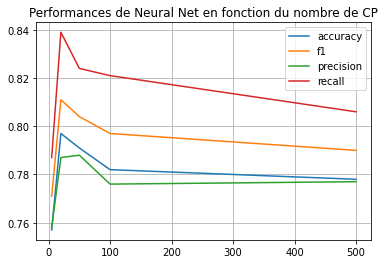

In [81]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Neural Net en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.852 with std 0.028
Mean f1 score 0.857 with std 0.029
Mean precision score 0.855 with std 0.022
Mean recall score 0.861 with std 0.048
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.834
 f1 : 0.835
 precision : 0.821
 recall : 0.849
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.854 with std 0.029
Mean f1 score 0.859 with std 0.029
Mean precision score 0.863 with std 0.033
Mean recall score 0.856 with std 0.038
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.807
 f1 : 0.812
 precision : 0.783
 recall : 0.842
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.831 with std 0.026
Mean f1 score 0.838 with std 0.025
Mean precision score 0.839 with std 0.033
Mean recall score 0.837 with std 0.028
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.814
 f1 : 0.817
 precision : 0.794
 recall 

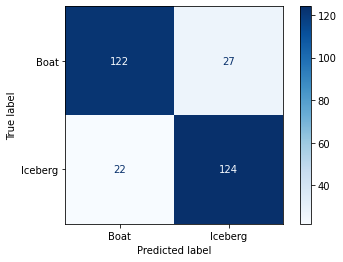

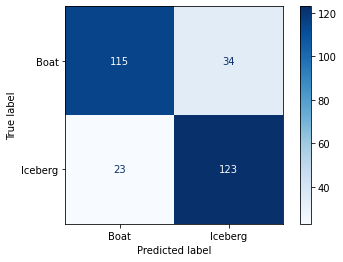

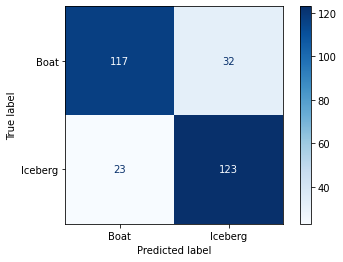

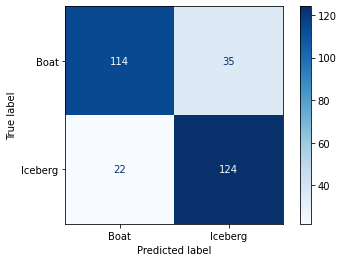

In [82]:


er.cv_cv = 3

train_scores_Adaboost = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(AdaBoostClassifier())
  train_scores_Adaboost.append(er.best_scores_t)

In [83]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_Adaboost]
y_p2 = [a.get('f1') for a in train_scores_Adaboost]
y_p3 = [a.get('precision') for a in train_scores_Adaboost]
y_p4 = [a.get('recall') for a in train_scores_Adaboost]

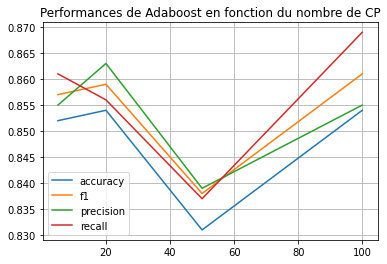

In [84]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Adaboost en fonction du nombre de CP')
plt.grid(True)
plt.show()